# Project 1 CNNs

This projects is for comparing between a Multilayer Perceptron and Convulusional Neural Network for classifying images of 32x32 pixels, 3 channels. Dataset has 50 000 images for training and 10 000 images for test, I split into training and validation; 40 000 and 10 000.

**Author:** Luis Angel Rojo Chavez
**Date:** October 29, 2025


In [2]:
import torch 
torch.set_float32_matmul_precision('high')
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
# --- Definir Transformaciones (copiadas de tus scripts) ---

# Transformaciones para ENTRENAMIENTO (con aumento)
# (Usa la versión más completa de tus scripts, ej. la de CNN)
transform_train_visualize = transforms.Compose([
    transforms.RandomCrop(32, padding=2),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(-15, 15)),
    transforms.ToTensor(),
])

# Transformaciones para VALIDACIÓN/TEST (limpias)
transform_test_visualize = transforms.Compose([
    transforms.ToTensor(),
])

# --- Cargar Datasets (solo para visualización) ---
# Usamos 'train=True' para poder comparar la misma imagen con y sin aumento
train_set_with_aug = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train_visualize
)
train_set_no_aug = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_test_visualize 
)

# Nombres de las clases
classes_viz = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:19<00:00, 8.56MB/s] 


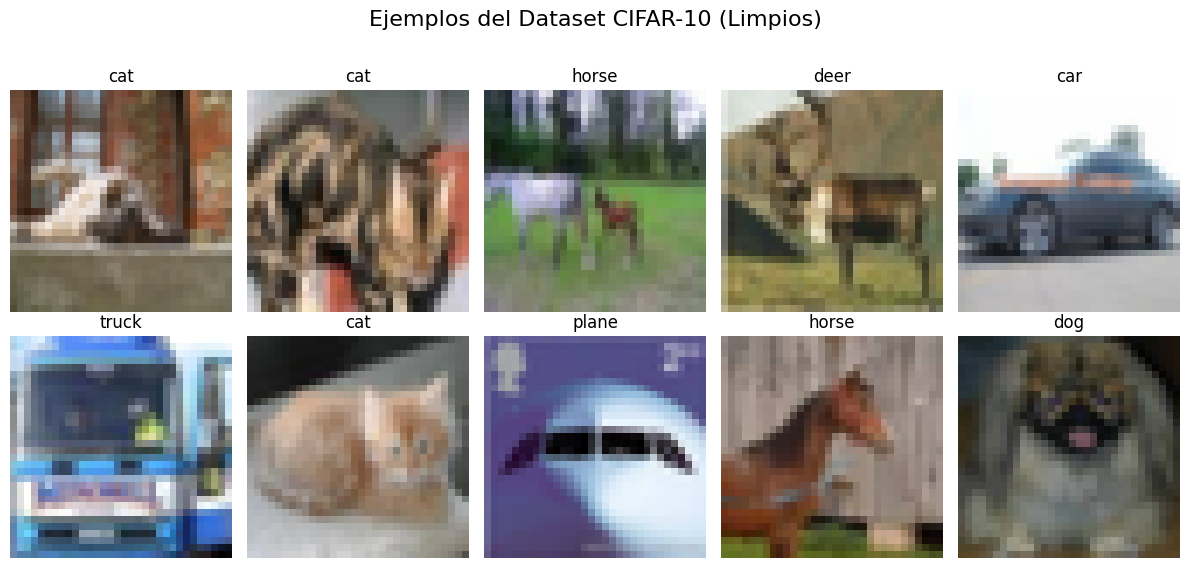

In [3]:
# --- Mostrar cuadrícula de imágenes limpias ---
plt.figure(figsize=(12, 6))

# Mostramos 10 imágenes aleatorias
indices_to_show = np.random.choice(len(train_set_no_aug), 10, replace=False)

for i, idx in enumerate(indices_to_show):
    # Cargar la imagen limpia
    img, label = train_set_no_aug[idx] # img es un Tensor (C, H, W)
    
    # Convertir de Tensor (C, H, W) a NumPy (H, W, C) para Matplotlib
    img_np = img.permute(1, 2, 0).numpy()
    
    # Crear subplot
    plt.subplot(2, 5, i + 1)
    plt.imshow(img_np)
    plt.title(f"{classes_viz[label]}")
    plt.axis('off')

plt.suptitle('Ejemplos del Dataset CIFAR-10 (Limpios)', fontsize=16)
plt.tight_layout(rect=[0, 0.01, 1, 0.96])
plt.show()

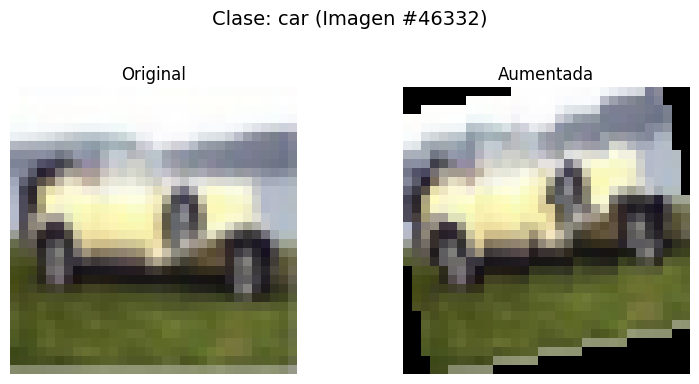

In [4]:
# --- Mostrar comparación Original vs. Aumentada ---

# Elegir una imagen aleatoria
idx_compare = np.random.randint(len(train_set_no_aug))

# Cargar ambas versiones
img_clean, label = train_set_no_aug[idx_compare]
img_aug, _ = train_set_with_aug[idx_compare]

# Convertir a NumPy para mostrar
img_clean_np = img_clean.permute(1, 2, 0).numpy()
img_aug_np = img_aug.permute(1, 2, 0).numpy()

# Graficar lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle(f"Clase: {classes_viz[label]} (Imagen #{idx_compare})", fontsize=14)

ax1.imshow(img_clean_np)
ax1.set_title("Original")
ax1.axis('off')

ax2.imshow(img_aug_np)
ax2.set_title("Aumentada")
ax2.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.show()

Modelo cargado desde 'best_cnn_model_exp1.pth'


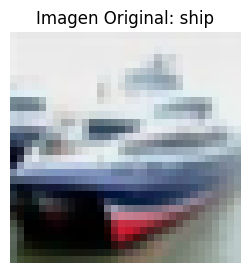

Predicción del modelo: ship


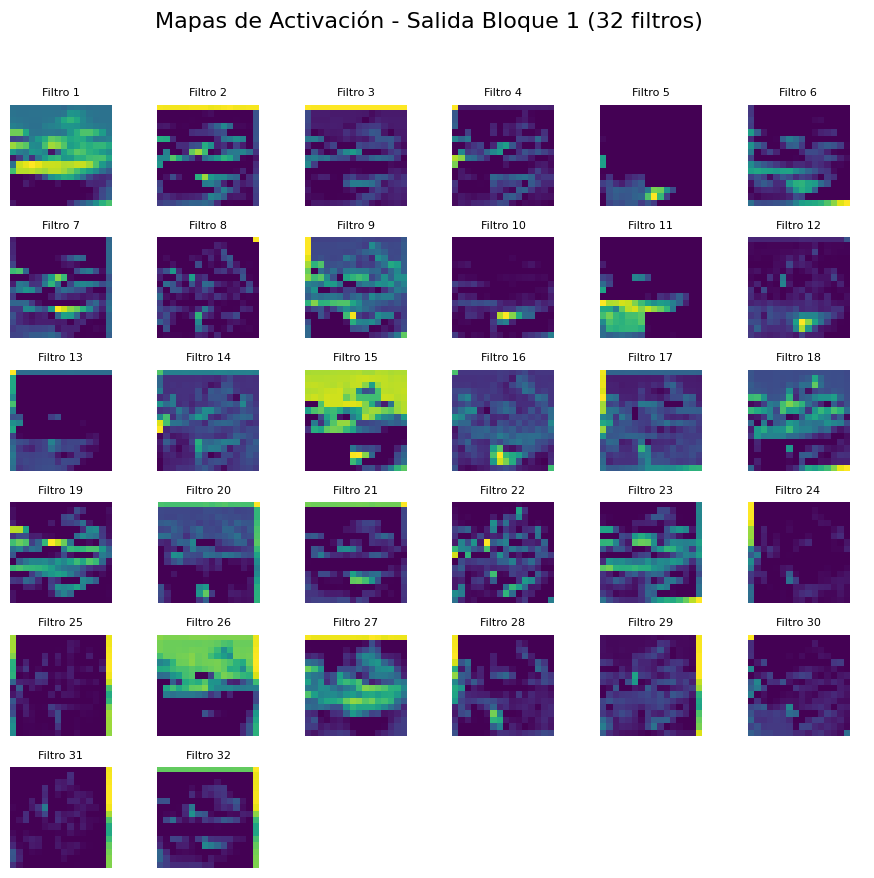

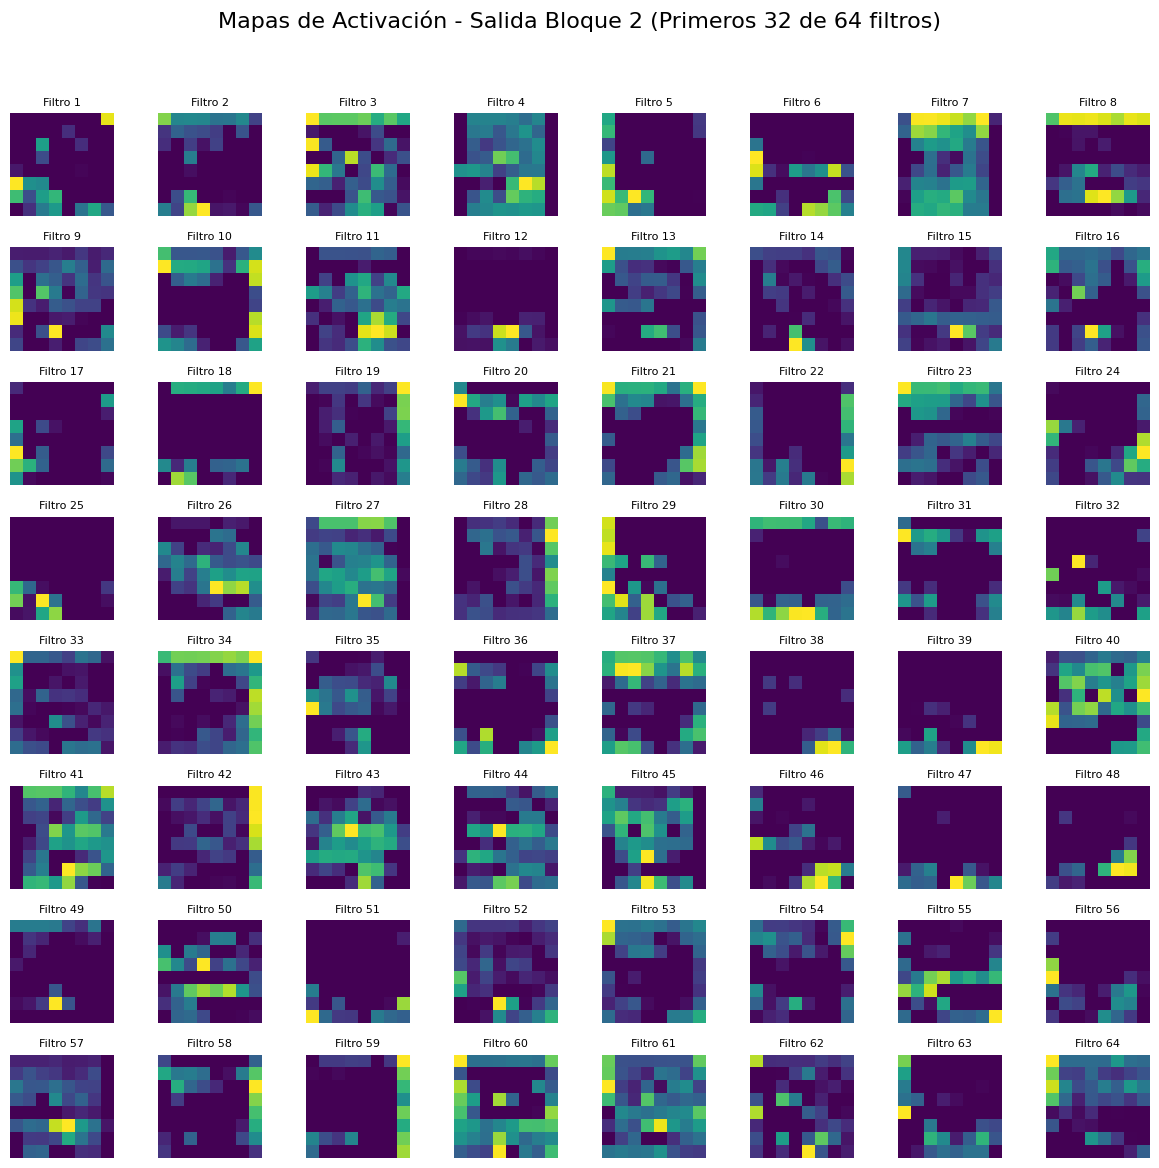

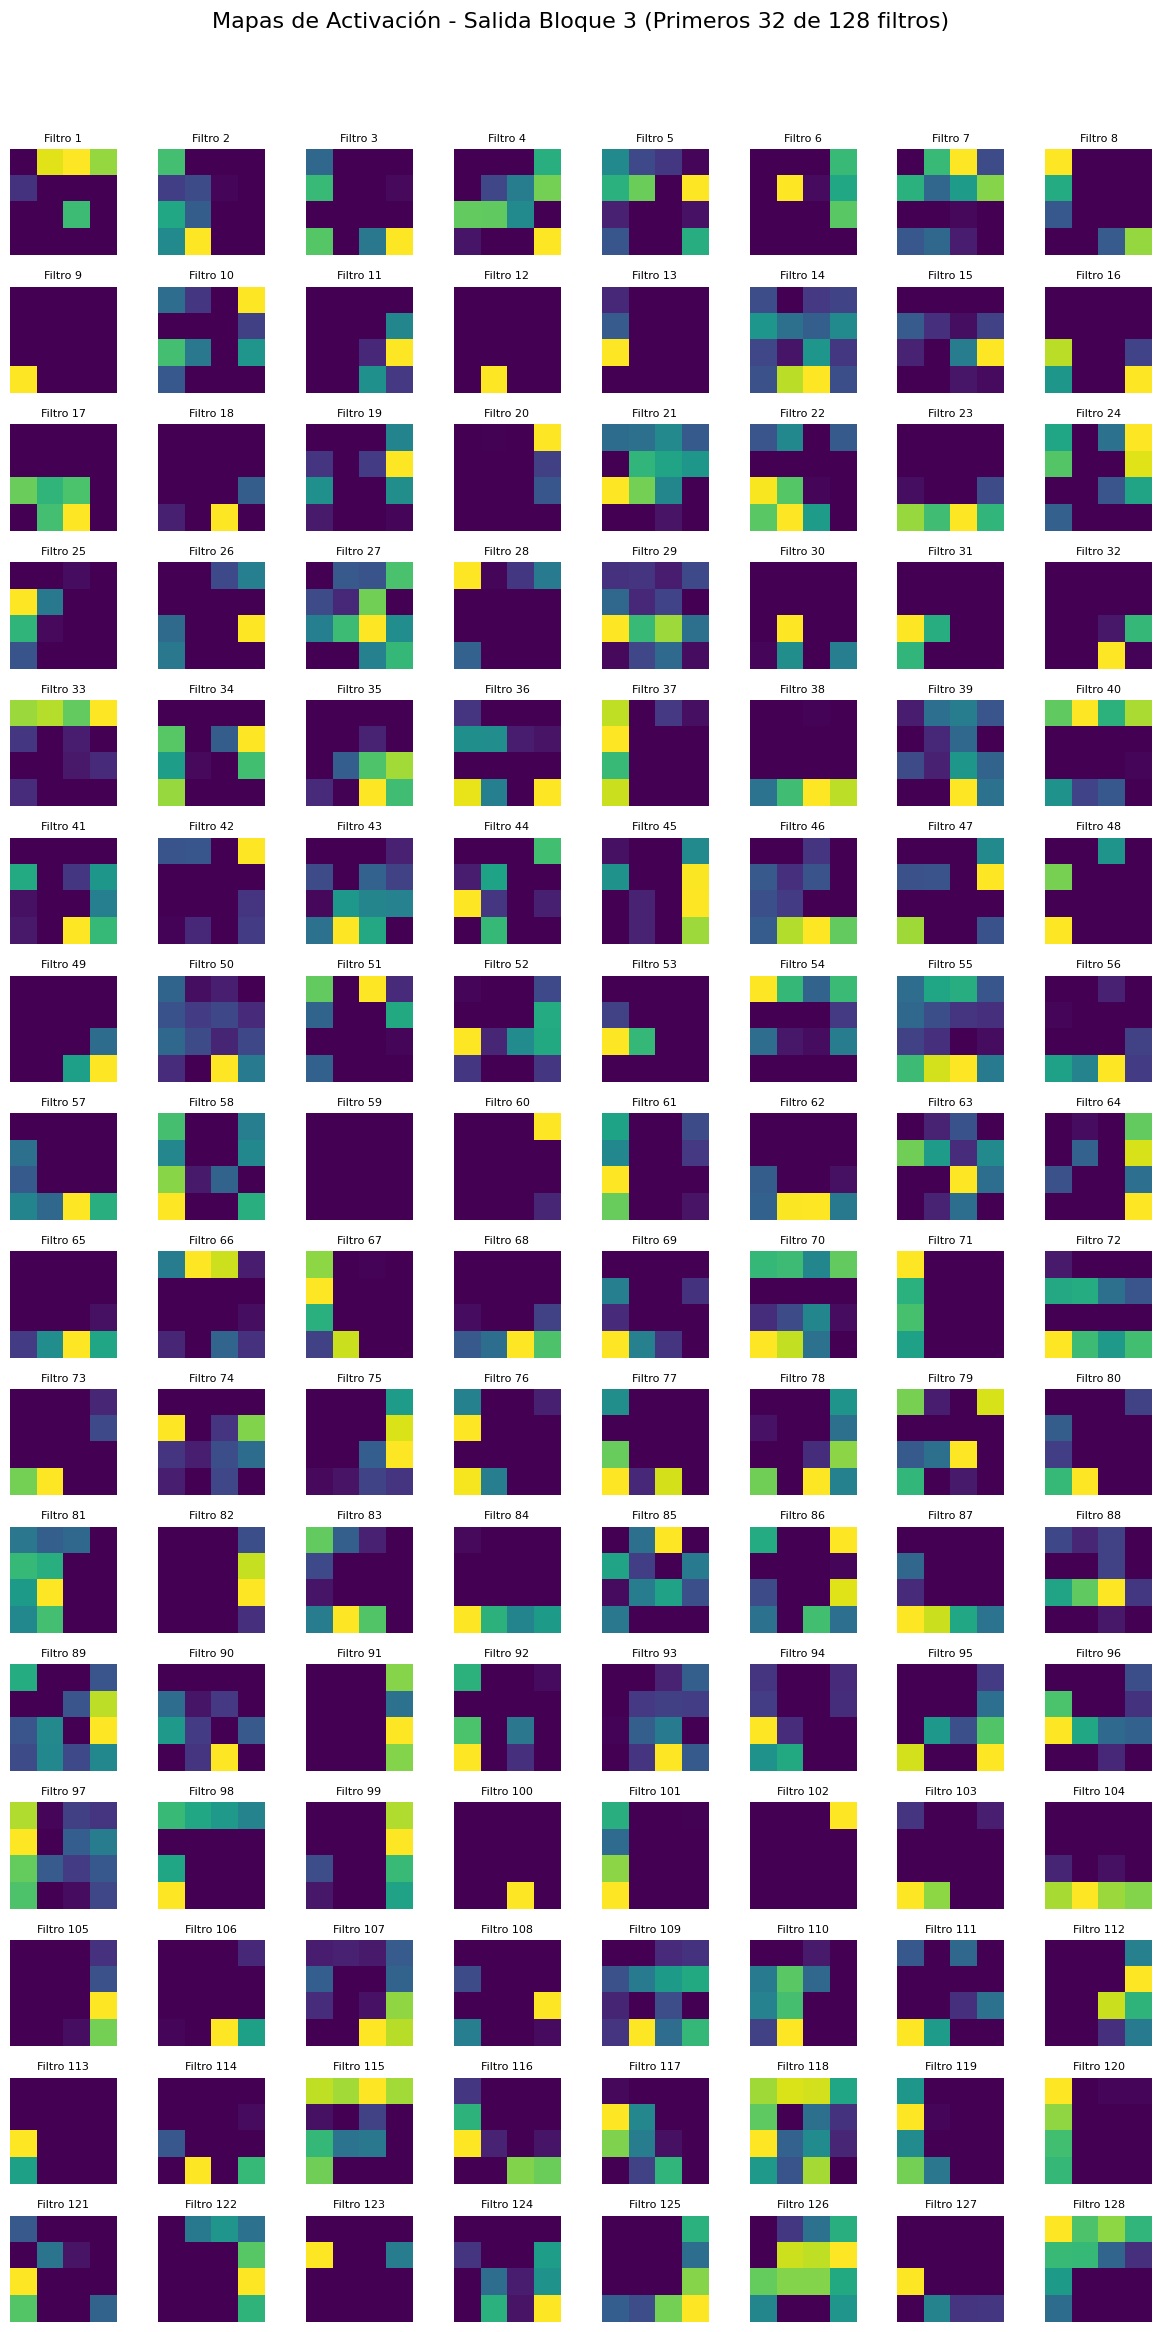

In [5]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os

# --- 1. Definir la MISMA arquitectura de CNN que usaste para entrenar ---
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # Bloque 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 16x16

            # Bloque 2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 8x8
            
            # Bloque 3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 4x4
        )
        
        # --- ARREGLO AQUÍ ---
        # El clasificador AHORA ES IDÉNTICO al del script de entrenamiento
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 128), # [1]
            nn.BatchNorm1d(128),       # [2]
            nn.ReLU(),                 # [3]
            nn.Dropout(0.2),           # [4] <-- ¡CAPA AÑADIDA!
            nn.Linear(128, num_classes)  # [5]
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x
# --- 2. Preparar los "Hooks" para capturar activaciones ---
activations = {}

def get_activation(name):
    # Esta función interna (hook) se llamará durante el forward pass
    def hook(model, input, output):
        # Almacenamos la salida 'output' en nuestro diccionario
        activations[name] = output.detach()
    return hook

# --- 3. Función para graficar los mapas de activación ---
def plot_activations(act_map, title, num_to_show=16):
    # act_map tiene forma [1, Num_Filtros, Alto, Ancho]
    act_map = act_map.squeeze(0).cpu()
    
    # Limitar el número de filtros a mostrar
    num_filters = min(act_map.shape[0], num_to_show)
    
    # Ajustar el grid para que sea más cuadrado si es posible
    grid_size_cols = int(np.ceil(np.sqrt(num_filters)))
    if num_filters <= 16:
        grid_size_cols = 8 # Mantener 8 para grids pequeños
    if num_filters > 32:
        grid_size_cols = 8 # Forzar 8 columnas para grids más grandes
        
    grid_size_rows = int(np.ceil(num_filters / grid_size_cols))
    
    fig, axes = plt.subplots(grid_size_rows, grid_size_cols, figsize=(grid_size_cols * 1.5, grid_size_rows * 1.5))
    fig.suptitle(title, fontsize=16)
    
    # Asegurarnos de que 'axes' sea siempre un array iterable
    if num_filters == 1:
        axes = np.array([axes])
    if grid_size_rows == 1 and grid_size_cols > 1:
        axes = axes.reshape(1, -1)
    
    for i, ax in enumerate(axes.flat):
        if i < num_filters:
            ax.imshow(act_map[i], cmap='viridis')
            ax.set_title(f"Filtro {i+1}", fontsize=8)
        ax.axis('off')
        
    plt.tight_layout(rect=[0, 0.01, 1, 0.95])
    plt.show()

# --- 4. Cargar Modelo y Ejecutar ---
# <-- CORRECCIÓN 1: El nombre del archivo debe coincidir con tu script de entrenamiento
MODEL_PATH = 'best_cnn_model_exp1.pth'
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() 
    else "cpu"
)

if not os.path.exists(MODEL_PATH):
    print(f"Error: No se encontró el archivo del modelo en '{MODEL_PATH}'")
else:
    # Instanciar el modelo y cargar los pesos
    model = SimpleCNN().to(device)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model.eval()
    print(f"Modelo cargado desde '{MODEL_PATH}'")

    # --- 5. Registrar los Hooks en las capas correctas ---
    # (Los índices vienen de los comentarios en la clase SimpleCNN)
    
    # Hook después del Bloque 1 (en la capa 3, el MaxPool2d)
    model.conv_layers[3].register_forward_hook(get_activation('block1'))
    
    # Hook después del Bloque 2 (en la capa 7, el MaxPool2d)
    model.conv_layers[7].register_forward_hook(get_activation('block2'))
    
    # Hook después del Bloque 3 (en la capa 11, el MaxPool2d)
    model.conv_layers[11].register_forward_hook(get_activation('block3'))

    # --- 6. Cargar una imagen de ejemplo ---
    transform_clean = transforms.Compose([transforms.ToTensor()])
    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_clean
    )
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    # Elige una imagen (puedes cambiar este índice)
    idx_example = 1 # Un coche
    img_clean, label = test_dataset[idx_example]
    
    # Preparar la imagen para el modelo (añadir dimensión de batch)
    img_batch = img_clean.unsqueeze(0).to(device)
    
    # Mostrar la imagen original
    plt.figure(figsize=(3, 3))
    plt.imshow(img_clean.permute(1, 2, 0).numpy())
    plt.title(f"Imagen Original: {classes[label]}")
    plt.axis('off')
    plt.show()

    # --- 7. Pasar la imagen por el modelo (esto ejecuta los hooks) ---
    with torch.no_grad():
        output = model(img_batch)
    
    prediction = torch.argmax(output)
    print(f"Predicción del modelo: {classes[prediction]}")

    # --- 8. Graficar las activaciones capturadas ---
    
    # Bloque 1: (32 filtros, 16x16)
    plot_activations(activations['block1'], 
                     'Mapas de Activación - Salida Bloque 1 (32 filtros)', 
                     num_to_show=32)

    # <-- CORRECCIÓN 2: Mostrar 32 filtros, no 64.
    plot_activations(activations['block2'], 
                     'Mapas de Activación - Salida Bloque 2 (Primeros 32 de 64 filtros)', 
                     num_to_show=64) 

    # <-- CORRECCIÓN 2: Mostrar 32 filtros, no 128.
    plot_activations(activations['block3'], 
                     'Mapas de Activación - Salida Bloque 3 (Primeros 32 de 128 filtros)', 
                     num_to_show=128)


### Summary
This notebook implements and evaluates a baseline Multi-Layer Perceptron (MLP) architecture for image classification on the CIFAR-10 dataset. The goal is to establish a performance baseline (accuracy, time, parameter count) before comparing it to a Convolutional Neural Network (CNN).

# Experiment 1

This experiment uses a baseline architecture for comparing CNN and MLP:

CNN Experiment 1 (Baseline): 3 blocks (32, 64, 128 filters) Classifier: 128 neurons
MLP
3 hidden layers (512, 256, 128)

In [6]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import os

# Configurar el estilo de Seaborn para gráficos más bonitos
sns.set_theme(style="whitegrid")
print("Librerías importadas.")

EXPERIMENT_FILES = [
    'results_CNN_exp1.pth',
    'results_MLP_exp1.pth'
]


Librerías importadas.


## 1.1 Carga de Archivos de Resultados
Cargamos los archivos `.pth` generados por los scripts de entrenamiento. Estos archivos contienen los historiales de entrenamiento, las predicciones finales y las métricas clave.

In [7]:
# --- Cargar datos de todos los experimentos ---
loaded_results = {}
all_histories_df = []
classes = []

def load_results(filename):
    """Carga un archivo de resultados de forma segura."""
    if os.path.exists(filename):
        print(f"Cargando: {filename}")
        
        # --- ¡CORRECCIÓN AQUÍ! ---
        # Necesitas 'weights_only=False' porque estás cargando
        # un diccionario con datos de Python/Numpy, no solo pesos.
        return torch.load(filename, weights_only=False) 
    
    else:
        print(f"¡ADVERTENCIA! No se encontró el archivo: {filename}")
        return None

for file in EXPERIMENT_FILES:
    results = load_results(file)
    if results:
        exp_name = results.get('experiment_name', file)
        loaded_results[exp_name] = results
        
        # Guardar clases (solo una vez)
        if not classes and 'classes' in results:
            classes = results['classes']
            
        # Preparar datos para las curvas de aprendizaje
        df = pd.DataFrame(results['history'])
        df['epoch'] = df.index + 1
        df['model'] = exp_name
        all_histories_df.append(df)

# Combinar todos los historiales en un solo DataFrame
if all_histories_df:
    full_history_df = pd.concat(all_histories_df, ignore_index=True)
    print(f"\nSe cargaron {len(loaded_results)} conjuntos de resultados.")
else:
    print("\nNo se cargó ningún resultado. Revisa los nombres de los archivos.")
    full_history_df = pd.DataFrame()

Cargando: results_CNN_exp1.pth
Cargando: results_MLP_exp1.pth

Se cargaron 2 conjuntos de resultados.


## 2.1. Resumen
Comparamos las métricas clave: precisión final, número de parámetros y tiempo de entrenamiento. Esto nos da una visión general del "costo-beneficio" de cada arquitectura.  

In [8]:
import pandas as pd

print("\n--- 9. Detailed View (Precision, Recall, F1) by Class ---")

# List to store data for each class and model
per_class_data = []

# Iterate over the results we already loaded
for name, data in loaded_results.items():
    report_dict = data.get('classification_report_dict', {})
    
    # Iterate over each class name
    for class_name in classes:
        if class_name in report_dict:
            class_metrics = report_dict[class_name]
            
            per_class_data.append({
                'Experiment': name,
                'Clase': class_name,
                'Precision': class_metrics.get('precision', 0.0),
                'Recall': class_metrics.get('recall', 0.0),
                'F1-Score': class_metrics.get('f1-score', 0.0),
            })

# Create the DataFrame
if per_class_data:
    per_class_df = pd.DataFrame(per_class_data)

    # --- Show all metrics (Detailed view) ---
    detailed_pivot = per_class_df.pivot(
        index='Clase', 
        columns='Experiment', 
        values=['Precision', 'Recall', 'F1-Score']
    )
    
    # Reorder columns to group by experiment (MLP -> P, R, F1 | CNN -> P, R, F1)
    # and then sort alphabetically by experiment name
    display(detailed_pivot.swaplevel(0, 1, axis=1).sort_index(axis=1).style.format("{:.3f}"))

else:
    print("No detailed classification report data was found.")


--- 9. Detailed View (Precision, Recall, F1) by Class ---


In [9]:
import numpy as np
import pandas as pd

print("\n--- 10. Comparison of Weighted Average Metrics & Runtimes ---")

weighted_avg_data = []

# Iterate over the loaded results
for name, data in loaded_results.items():
    report_dict = data.get('classification_report_dict', {})
    
    # Extract the 'weighted avg' metrics
    weighted_avg_metrics = report_dict.get('weighted avg', {})
    
    if weighted_avg_metrics:
        weighted_avg_data.append({
            'Experiment': name,
            
            # --- Performance Metrics ---
            'Test Accuracy': data.get('test_accuracy', 0.0),
            'F1-Score (Weighted)': weighted_avg_metrics.get('f1-score', 0.0),
            'Precision (Weighted)': weighted_avg_metrics.get('precision', 0.0),
            'Recall (Weighted)': weighted_avg_metrics.get('recall', 0.0),
            
            # --- Cost Metrics (Runtimes & Params) ---
            'Total Params': data.get('total_params', 0), # <-- ADDED
            'Total Time (min)': data.get('total_training_time_sec', 0.0) / 60.0,
            'Time / Epoch (s)': np.mean(data['history'].get('epoch_time', [0.0])),
            'Test Time (s)': data.get('total_inference_time_sec', 0.0)
        })

# Create the DataFrame
if weighted_avg_data:
    # Reorder columns for logical grouping
    column_order = [
        'Test Accuracy', 
        'F1-Score (Weighted)', 
        'Precision (Weighted)', 
        'Recall (Weighted)',
        'Total Params', # <-- ADDED
        'Total Time (min)', 
        'Time / Epoch (s)',
        'Test Time (s)'
    ]
    
    weighted_avg_df = pd.DataFrame(weighted_avg_data).set_index('Experiment')
    weighted_avg_df = weighted_avg_df[column_order] # Apply order
    
    # Format the output
    format_dict = {
        'Test Accuracy': '{:.2f}%',
        'F1-Score (Weighted)': '{:.3f}',
        'Precision (Weighted)': '{:.3f}',
        'Recall (Weighted)': '{:.3f}',
        'Total Params': '{:,}', # <-- ADDED (adds comma separator)
        'Total Time (min)': '{:.2f}',
        'Time / Epoch (s)': '{:.2f}',
        'Test Time (s)': '{:.2f}'
    }
    
    display(weighted_avg_df.style.format(format_dict))
else:
    print("No 'weighted avg' data found in reports.")


--- 10. Comparison of Weighted Average Metrics & Runtimes ---


,Test Accuracy,F1-Score (Weighted),Precision (Weighted),Recall (Weighted),Total Params,Total Time (min),Time / Epoch (s),Test Time (s)
Experiment,,,,,,,,
CNN Exp 1 (Baseline),83.67%,0.836,0.838,0.837,"357,514",7.83,9.40,0.76
MLP Exp 1 (Baseline),51.78%,0.516,0.518,0.518,"1,738,890",3.62,4.35,0.43


## 3.1 Curvas de Aprendizaje (Accuracy y Pérdida)
Esta es la visualización más importante. Muestra cómo aprendió cada modelo a lo largo del tiempo.

* **Líneas Sólidas (-):** Accuracy/Pérdida de **Validación** (qué tan bien generaliza).
* **Líneas Punteadas (--):** Accuracy/Pérdida de **Entrenamiento** (qué tan bien memoriza).
* **Sobreajuste (Overfitting):** Ocurre cuando la línea de entrenamiento sigue mejorando mientras que la de validación se estanca o empeora (la brecha entre ambas se amplía).

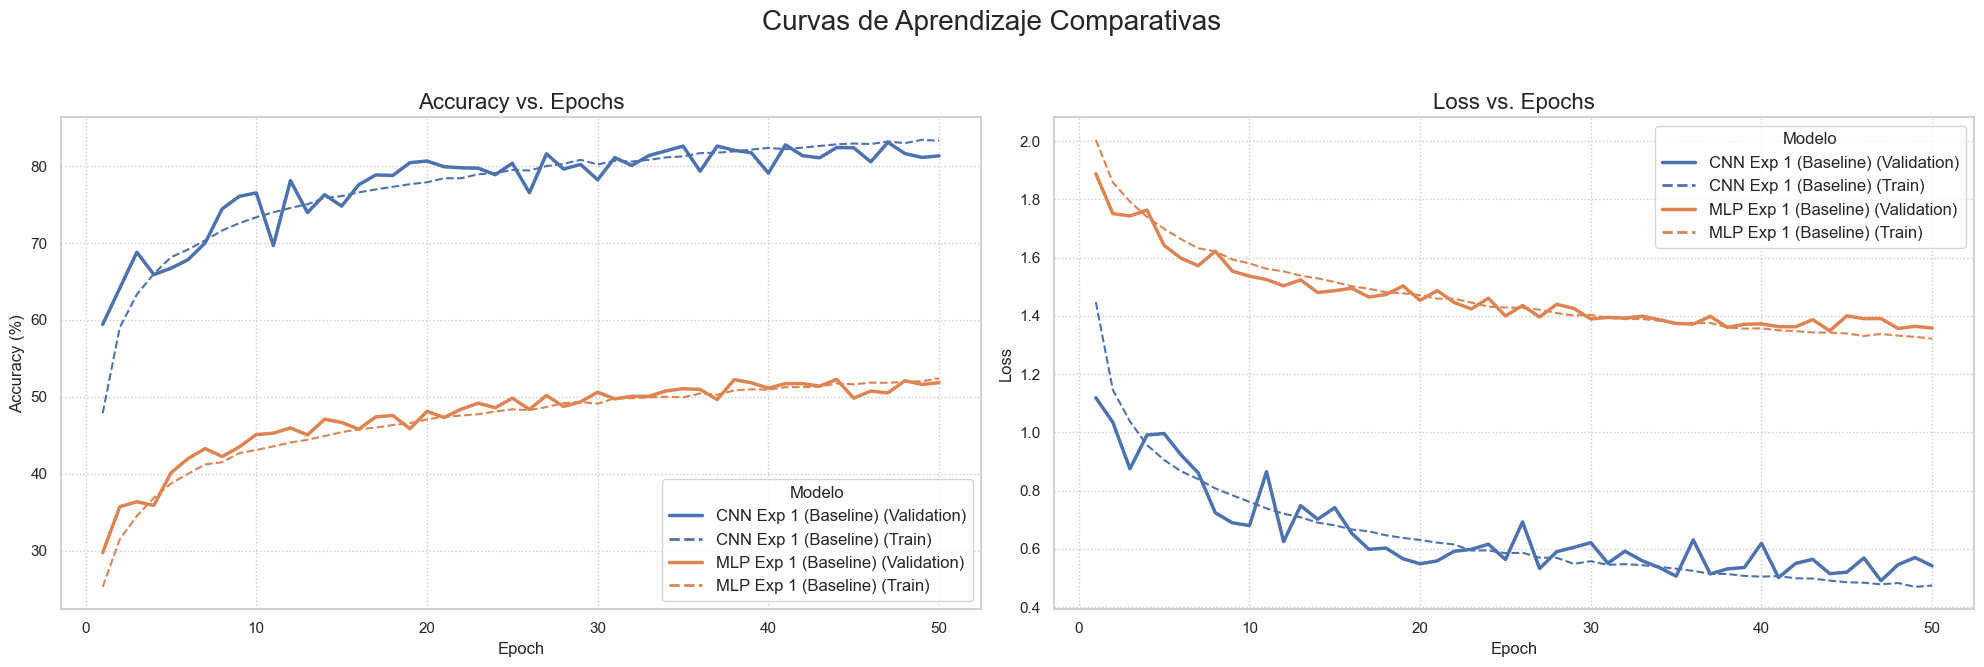

In [10]:
# Importar Line2D para crear la leyenda manual
from matplotlib.lines import Line2D

if not full_history_df.empty:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
    fig.suptitle('Curvas de Aprendizaje Comparativas', fontsize=20)
    
    # --- Obtener nombres y colores de modelos ---
    # Esto nos permite crear la leyenda dinámicamente
    model_names = full_history_df['model'].unique()
    palette = sns.color_palette(n_colors=len(model_names))
    
    # --- Gráfica 1: Precisión (Accuracy) ---
    sns.lineplot(data=full_history_df, x='epoch', y='val_acc', hue='model', 
                 palette=palette, linestyle='-', linewidth=2.5, ax=ax1, legend=False)
    sns.lineplot(data=full_history_df, x='epoch', y='train_acc', hue='model', 
                 palette=palette, linestyle='--', ax=ax1, legend=False)

    ax1.set_title('Accuracy vs. Epochs', fontsize=16)
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_xlabel('Epoch')
    ax1.grid(True, linestyle=':') # Añadir grid
    
    # --- Gráfica 2: Pérdida (Loss) ---
    sns.lineplot(data=full_history_df, x='epoch', y='val_loss', hue='model', 
                 palette=palette, linestyle='-', linewidth=2.5, ax=ax2, legend=False)
    # ¡LÍNEA AÑADIDA!
    sns.lineplot(data=full_history_df, x='epoch', y='train_loss', hue='model', 
                 palette=palette, linestyle='--', ax=ax2, legend=False)
    
    ax2.set_title('Loss vs. Epochs', fontsize=16)
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.grid(True, linestyle=':') # Añadir grid
    
    # --- Crear Leyenda Manual "Bien Definida" ---
    legend_elements = []
    for i, name in enumerate(model_names):
        legend_elements.append(
            Line2D([0], [0], color=palette[i], lw=2.5, label=f'{name} (Validation)')
        )
        legend_elements.append(
            Line2D([0], [0], color=palette[i], lw=2, ls='--', label=f'{name} (Train)')
        )

    # Aplicar la leyenda en la mejor ubicación "en medio"
    ax1.legend(handles=legend_elements, loc='best', title='Modelo', fontsize=12)
    ax2.legend(handles=legend_elements, loc='best', title='Modelo', fontsize=12)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustar para el super-título
    plt.savefig('comparative_learning_curves_exp1.png', dpi=300)
    plt.show()
else:
    print("No hay datos de historial para graficar.")

## 4.1 Matrices de Confusión
Estas matrices nos muestran *dónde* se confunden los modelos. La diagonal principal (de arriba-izquierda a abajo-derecha) representa las predicciones correctas. Los números fuera de la diagonal son errores.

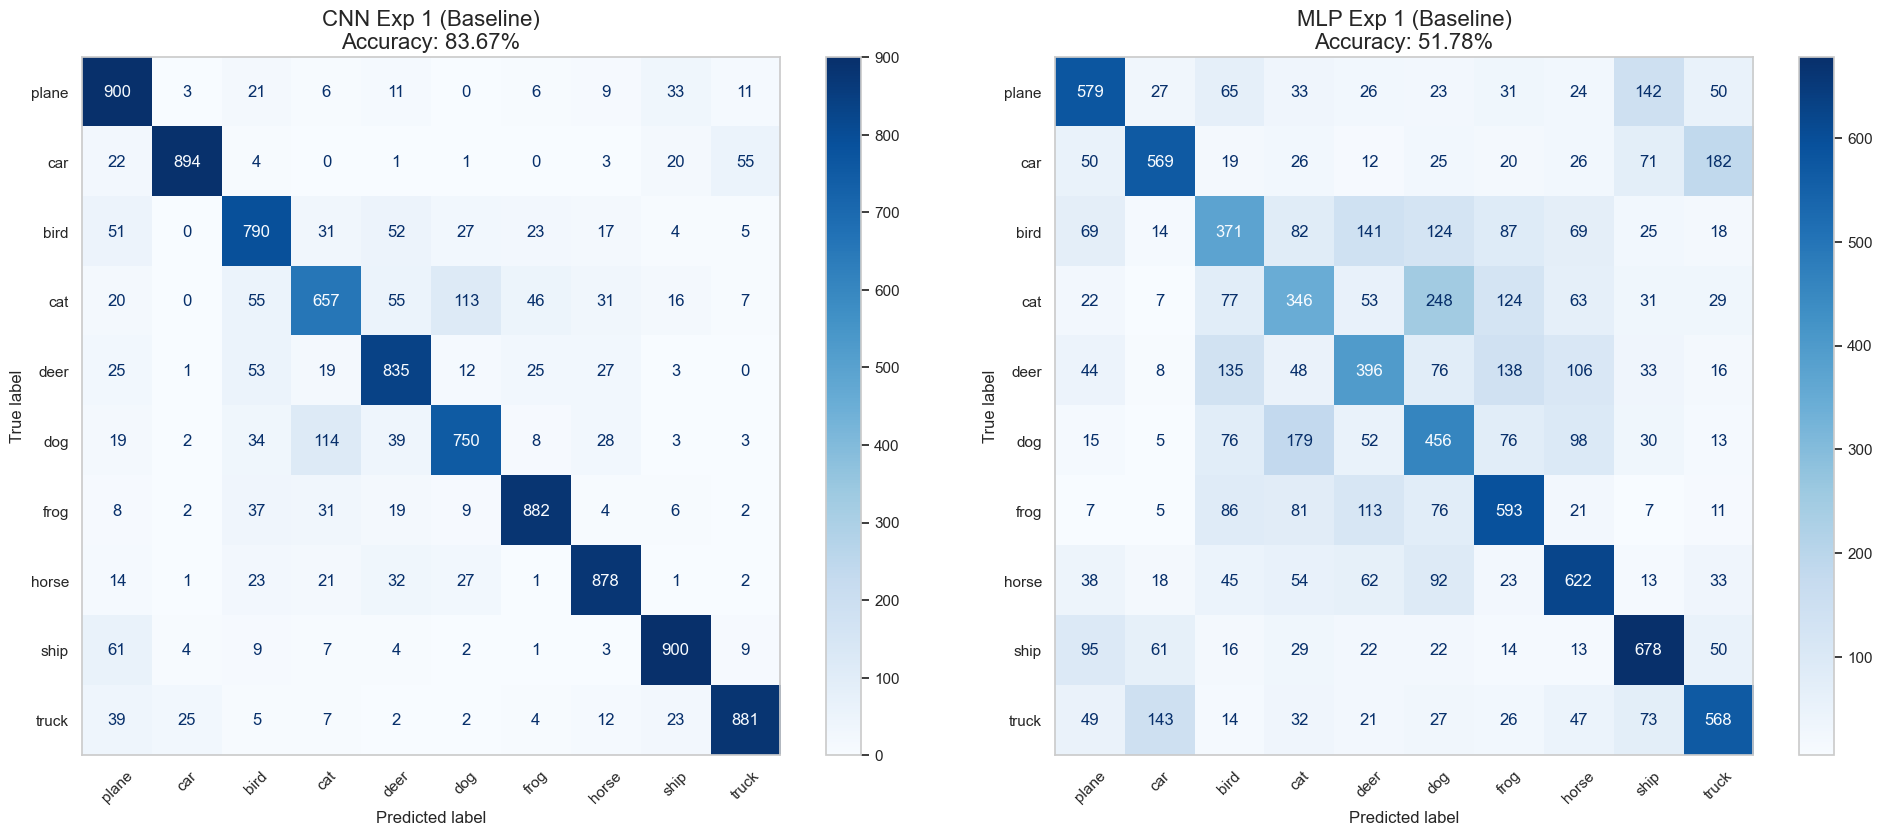

In [11]:
# --- Graficar Matrices de Confusión ---
if loaded_results:
    n_exp = len(loaded_results)
    # Crear una cuadrícula (máx 2 columnas)
    ncols = min(n_exp, 2)
    nrows = (n_exp + 1) // ncols
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10 * ncols, 8 * nrows), squeeze=False)
    
    # Iterar sobre los resultados y los ejes
    for i, (name, data) in enumerate(loaded_results.items()):
        ax = axes.flat[i]
        
        cm = confusion_matrix(data['all_labels'], data['all_predictions'])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
        
        disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
        
        # --- LÍNEA AÑADIDA ---
        # Desactiva la cuadrícula de fondo para esta gráfica
        ax.grid(False) 
        # ---
        
        ax.set_title(f"{name}\nAccuracy: {data['test_accuracy']:.2f}%", fontsize=16)

    # Ocultar ejes no usados
    for j in range(i + 1, len(axes.flat)):
        axes.flat[j].set_visible(False)
        
    plt.tight_layout()
    plt.savefig('comparative_confusion_matrices_exp1.png', dpi=300)
    plt.show()
else:
    print("No hay resultados cargados para mostrar matrices.")

## 5.1 Conclusión del Análisis

* **Precisión:** ¿Qué modelo logró mayor precisión de validación? Como arquitecturas base del proyecto tenemos un mejor rendimiento de parte de la CNN por alrededor de 30 puntos.
* **Sobreajuste:** ¿Qué modelo mostró una brecha más grande entre entrenamiento y validación? La MLP parece estar más cerca su curva de entrenamiento a la de validación.
* **Parámetros:** ¿Cómo se compara la eficiencia? La CNN con muchos menos parametros tiene un mucho mejor accuracy.
* **Confusiones:** ¿Hubo clases específicas (ej. 'gato' vs 'perro', 'coche' vs 'camión') donde la CNN fue notablemente mejor? Las peores clases en MLP son bird y cat pero en la CNN son cat y dog.

# Experiment 2

Aumentamos los parametros en la CNN aumentando los filtros de cada bloque de convolución, 64, 128, 256 y eso lo pasamos a 128 neuronas.

In [12]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import os

# Configurar el estilo de Seaborn para gráficos más bonitos
sns.set_theme(style="whitegrid")
print("Librerías importadas.")

EXPERIMENT_FILES = [
    'results_CNN_exp2.pth',
    'results_MLP_exp2.pth'
]


Librerías importadas.


## 1.1 Carga de Archivos de Resultados
Cargamos los archivos `.pth` generados por los scripts de entrenamiento. Estos archivos contienen los historiales de entrenamiento, las predicciones finales y las métricas clave.

In [13]:
# --- Cargar datos de todos los experimentos ---
loaded_results = {}
all_histories_df = []
classes = []

def load_results(filename):
    """Carga un archivo de resultados de forma segura."""
    if os.path.exists(filename):
        print(f"Cargando: {filename}")
        
        # --- ¡CORRECCIÓN AQUÍ! ---
        # Necesitas 'weights_only=False' porque estás cargando
        # un diccionario con datos de Python/Numpy, no solo pesos.
        return torch.load(filename, weights_only=False) 
    
    else:
        print(f"¡ADVERTENCIA! No se encontró el archivo: {filename}")
        return None

for file in EXPERIMENT_FILES:
    results = load_results(file)
    if results:
        exp_name = results.get('experiment_name', file)
        loaded_results[exp_name] = results
        
        # Guardar clases (solo una vez)
        if not classes and 'classes' in results:
            classes = results['classes']
            
        # Preparar datos para las curvas de aprendizaje
        df = pd.DataFrame(results['history'])
        df['epoch'] = df.index + 1
        df['model'] = exp_name
        all_histories_df.append(df)

# Combinar todos los historiales en un solo DataFrame
if all_histories_df:
    full_history_df = pd.concat(all_histories_df, ignore_index=True)
    print(f"\nSe cargaron {len(loaded_results)} conjuntos de resultados.")
else:
    print("\nNo se cargó ningún resultado. Revisa los nombres de los archivos.")
    full_history_df = pd.DataFrame()

Cargando: results_CNN_exp2.pth
Cargando: results_MLP_exp2.pth

Se cargaron 2 conjuntos de resultados.


## 2.1. Resumen de Alto Nivel (Tabla Comparativa)
Comparamos las métricas clave: precisión final, número de parámetros y tiempo de entrenamiento. Esto nos da una visión general del "costo-beneficio" de cada arquitectura.  

In [14]:
import pandas as pd

print("\n--- 9. Detailed View (Precision, Recall, F1) by Class ---")

# List to store data for each class and model
per_class_data = []

# Iterate over the results we already loaded
for name, data in loaded_results.items():
    report_dict = data.get('classification_report_dict', {})
    
    # Iterate over each class name
    for class_name in classes:
        if class_name in report_dict:
            class_metrics = report_dict[class_name]
            
            per_class_data.append({
                'Experiment': name,
                'Clase': class_name,
                'Precision': class_metrics.get('precision', 0.0),
                'Recall': class_metrics.get('recall', 0.0),
                'F1-Score': class_metrics.get('f1-score', 0.0),
            })

# Create the DataFrame
if per_class_data:
    per_class_df = pd.DataFrame(per_class_data)

    # --- Show all metrics (Detailed view) ---
    detailed_pivot = per_class_df.pivot(
        index='Clase', 
        columns='Experiment', 
        values=['Precision', 'Recall', 'F1-Score']
    )
    
    # Reorder columns to group by experiment (MLP -> P, R, F1 | CNN -> P, R, F1)
    # and then sort alphabetically by experiment name
    display(detailed_pivot.swaplevel(0, 1, axis=1).sort_index(axis=1).style.format("{:.3f}"))

else:
    print("No detailed classification report data was found.")


--- 9. Detailed View (Precision, Recall, F1) by Class ---


In [15]:
import numpy as np
import pandas as pd

print("\n--- 10. Comparison of Weighted Average Metrics & Runtimes ---")

weighted_avg_data = []

# Iterate over the loaded results
for name, data in loaded_results.items():
    report_dict = data.get('classification_report_dict', {})
    
    # Extract the 'weighted avg' metrics
    weighted_avg_metrics = report_dict.get('weighted avg', {})
    
    if weighted_avg_metrics:
        weighted_avg_data.append({
            'Experiment': name,
            
            # --- Performance Metrics ---
            'Test Accuracy': data.get('test_accuracy', 0.0),
            'F1-Score (Weighted)': weighted_avg_metrics.get('f1-score', 0.0),
            'Precision (Weighted)': weighted_avg_metrics.get('precision', 0.0),
            'Recall (Weighted)': weighted_avg_metrics.get('recall', 0.0),
            
            # --- Cost Metrics (Runtimes & Params) ---
            'Total Params': data.get('total_params', 0), # <-- ADDED
            'Total Time (min)': data.get('total_training_time_sec', 0.0) / 60.0,
            'Time / Epoch (s)': np.mean(data['history'].get('epoch_time', [0.0])),
            'Test Time (s)': data.get('total_inference_time_sec', 0.0)
        })

# Create the DataFrame
if weighted_avg_data:
    # Reorder columns for logical grouping
    column_order = [
        'Test Accuracy', 
        'F1-Score (Weighted)', 
        'Precision (Weighted)', 
        'Recall (Weighted)',
        'Total Params', # <-- ADDED
        'Total Time (min)', 
        'Time / Epoch (s)',
        'Test Time (s)'
    ]
    
    weighted_avg_df = pd.DataFrame(weighted_avg_data).set_index('Experiment')
    weighted_avg_df = weighted_avg_df[column_order] # Apply order
    
    # Format the output
    format_dict = {
        'Test Accuracy': '{:.2f}%',
        'F1-Score (Weighted)': '{:.3f}',
        'Precision (Weighted)': '{:.3f}',
        'Recall (Weighted)': '{:.3f}',
        'Total Params': '{:,}', # <-- ADDED (adds comma separator)
        'Total Time (min)': '{:.2f}',
        'Time / Epoch (s)': '{:.2f}',
        'Test Time (s)': '{:.2f}'
    }
    
    display(weighted_avg_df.style.format(format_dict))
else:
    print("No 'weighted avg' data found in reports.")


--- 10. Comparison of Weighted Average Metrics & Runtimes ---


,Test Accuracy,F1-Score (Weighted),Precision (Weighted),Recall (Weighted),Total Params,Total Time (min),Time / Epoch (s),Test Time (s)
Experiment,,,,,,,,
CNN Exp 2 (more parameters),86.28%,0.862,0.862,0.863,"1,423,626",13.61,16.33,1.02
MLP Exp 2 (no augmentation),50.45%,0.501,0.509,0.504,"1,465,912",3.22,3.87,0.44


## 3.1 Curvas de Aprendizaje (Precisión y Pérdida)
Esta es la visualización más importante. Muestra cómo aprendió cada modelo a lo largo del tiempo.

* **Líneas Sólidas (-):** Precisión/Pérdida de **Validación** (qué tan bien generaliza).
* **Líneas Punteadas (--):** Precisión/Pérdida de **Entrenamiento** (qué tan bien memoriza).
* **Sobreajuste (Overfitting):** Ocurre cuando la línea de entrenamiento sigue mejorando mientras que la de validación se estanca o empeora (la brecha entre ambas se amplía).

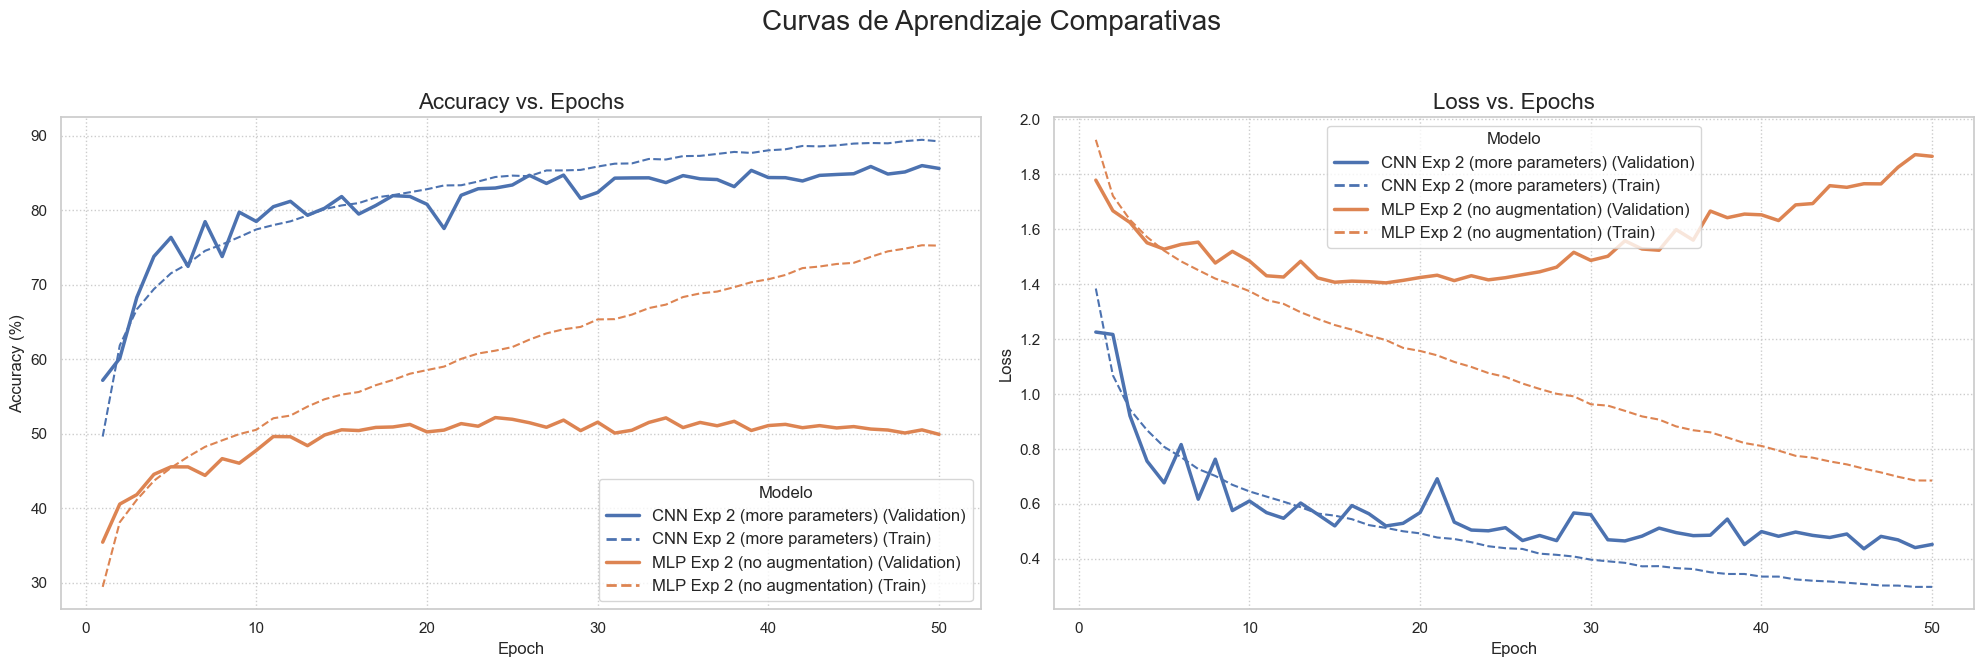

In [16]:
# Importar Line2D para crear la leyenda manual
from matplotlib.lines import Line2D

if not full_history_df.empty:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
    fig.suptitle('Curvas de Aprendizaje Comparativas', fontsize=20)
    
    # --- Obtener nombres y colores de modelos ---
    # Esto nos permite crear la leyenda dinámicamente
    model_names = full_history_df['model'].unique()
    palette = sns.color_palette(n_colors=len(model_names))
    
    # --- Gráfica 1: Precisión (Accuracy) ---
    sns.lineplot(data=full_history_df, x='epoch', y='val_acc', hue='model', 
                 palette=palette, linestyle='-', linewidth=2.5, ax=ax1, legend=False)
    sns.lineplot(data=full_history_df, x='epoch', y='train_acc', hue='model', 
                 palette=palette, linestyle='--', ax=ax1, legend=False)

    ax1.set_title('Accuracy vs. Epochs', fontsize=16)
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_xlabel('Epoch')
    ax1.grid(True, linestyle=':') # Añadir grid
    
    # --- Gráfica 2: Pérdida (Loss) ---
    sns.lineplot(data=full_history_df, x='epoch', y='val_loss', hue='model', 
                 palette=palette, linestyle='-', linewidth=2.5, ax=ax2, legend=False)
    # ¡LÍNEA AÑADIDA!
    sns.lineplot(data=full_history_df, x='epoch', y='train_loss', hue='model', 
                 palette=palette, linestyle='--', ax=ax2, legend=False)
    
    ax2.set_title('Loss vs. Epochs', fontsize=16)
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.grid(True, linestyle=':') # Añadir grid
    
    # --- Crear Leyenda Manual "Bien Definida" ---
    legend_elements = []
    for i, name in enumerate(model_names):
        legend_elements.append(
            Line2D([0], [0], color=palette[i], lw=2.5, label=f'{name} (Validation)')
        )
        legend_elements.append(
            Line2D([0], [0], color=palette[i], lw=2, ls='--', label=f'{name} (Train)')
        )

    # Aplicar la leyenda en la mejor ubicación "en medio"
    ax1.legend(handles=legend_elements, loc='best', title='Modelo', fontsize=12)
    ax2.legend(handles=legend_elements, loc='best', title='Modelo', fontsize=12)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustar para el super-título
    plt.savefig('comparative_learning_curves_exp2.png', dpi=300)
    plt.show()
else:
    print("No hay datos de historial para graficar.")

## 4.1 Matrices de Confusión
Estas matrices nos muestran *dónde* se confunden los modelos. La diagonal principal (de arriba-izquierda a abajo-derecha) representa las predicciones correctas. Los números fuera de la diagonal son errores.

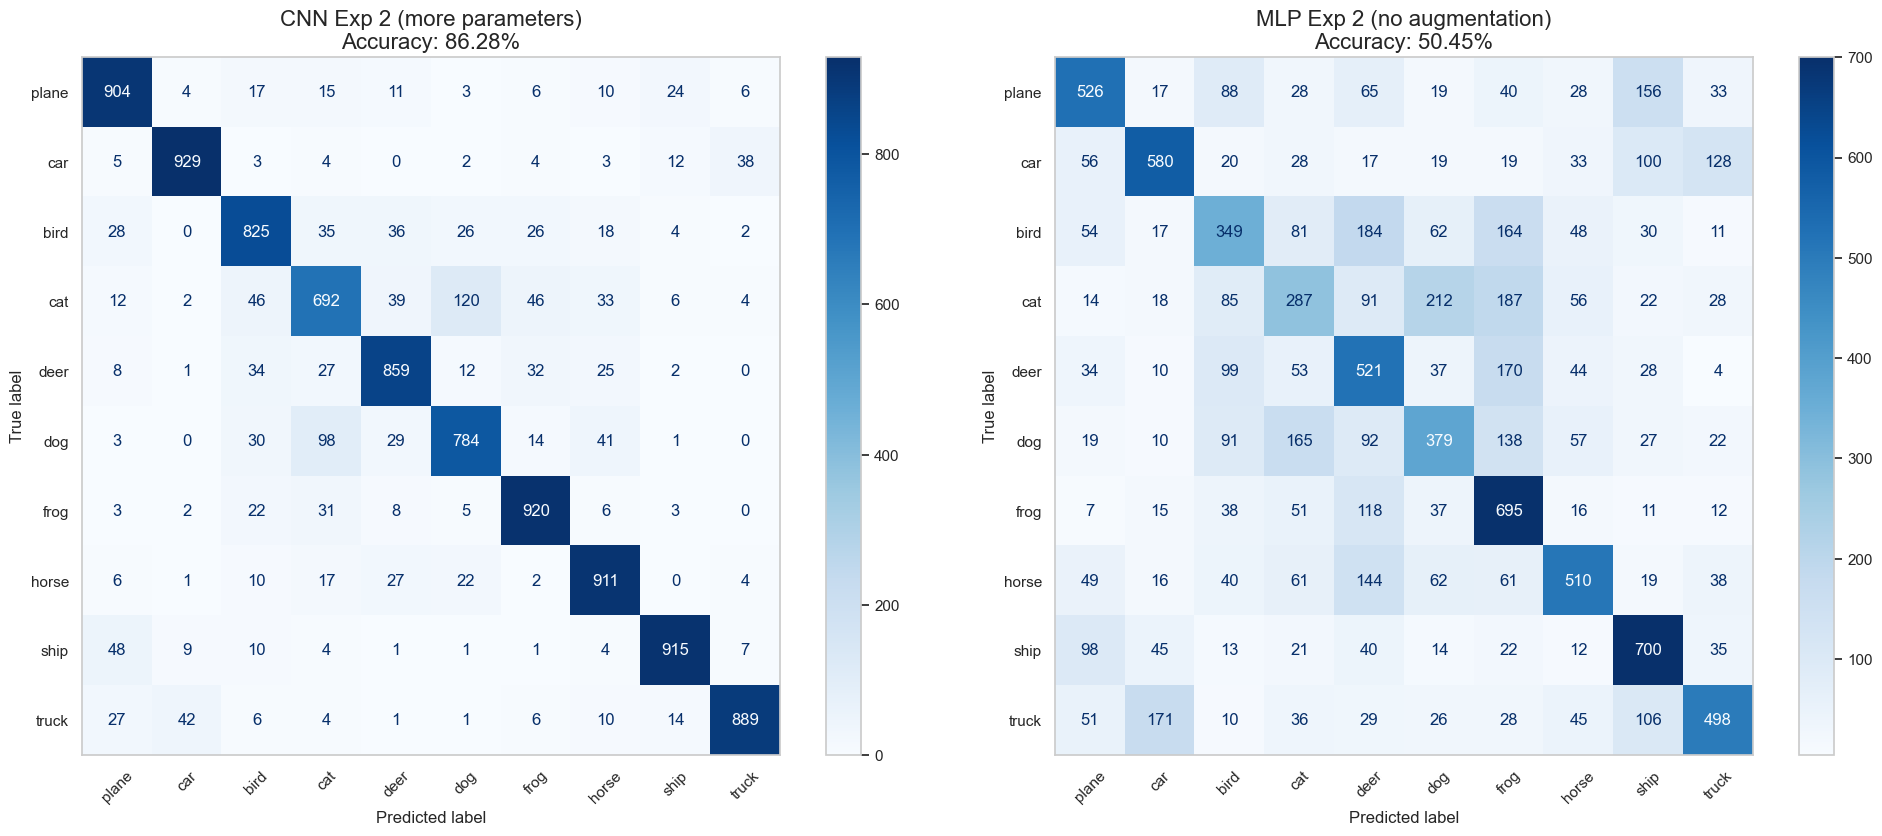

In [17]:
# --- Graficar Matrices de Confusión ---
if loaded_results:
    n_exp = len(loaded_results)
    # Crear una cuadrícula (máx 2 columnas)
    ncols = min(n_exp, 2)
    nrows = (n_exp + 1) // ncols
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10 * ncols, 8 * nrows), squeeze=False)
    
    # Iterar sobre los resultados y los ejes
    for i, (name, data) in enumerate(loaded_results.items()):
        ax = axes.flat[i]
        
        cm = confusion_matrix(data['all_labels'], data['all_predictions'])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
        
        disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
        
        # --- LÍNEA AÑADIDA ---
        # Desactiva la cuadrícula de fondo para esta gráfica
        ax.grid(False) 
        # ---
        
        ax.set_title(f"{name}\nAccuracy: {data['test_accuracy']:.2f}%", fontsize=16)

    # Ocultar ejes no usados
    for j in range(i + 1, len(axes.flat)):
        axes.flat[j].set_visible(False)
        
    plt.tight_layout()
    plt.savefig('comparative_confusion_matrices_exp2.png', dpi=300)
    plt.show()
else:
    print("No hay resultados cargados para mostrar matrices.")

## 5.1 Conclusión del Análisis del experimento 2

Precisión: La CNN es drásticamente superior, superando al MLP por aproximadamente 36 puntos porcentuales.

Sobreajuste: El MLP sufre de un sobreajuste severo, visible en la gran brecha entre sus curvas de entrenamiento y validación, tentativamente por no usar data augmentation. La CNN generaliza mucho mejor.

Eficiencia: La CNN es mucho más eficiente. Logró una precisión superior con los mismos parámetros que el MLP y mejoró el porcentaje respecto al experimento 1 (que tenía menos).

Confusiones: El MLP comete errores más graves (ej. "bird" vs "cat"), mientras que la CNN comete confusiones más lógicas (ej. "cat" vs "dog"), sugiriendo que aprende características de mayor calidad.

# Experimento 3

En este experimento se reducen los parámetros del MLP hasta aproximadamente los parametros del CNN del experimento 1, usando una sola capa oculta de 116 neuronas en el MLP sin data augmentation.

In [18]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import os

# Configurar el estilo de Seaborn para gráficos más bonitos
sns.set_theme(style="whitegrid")
print("Librerías importadas.")

EXPERIMENT_FILES = [
    'results_CNN_exp3.pth',
    'results_MLP_exp3.pth'
]


Librerías importadas.


## 1.1 Carga de Archivos de Resultados
Cargamos los archivos `.pth` generados por los scripts de entrenamiento. Estos archivos contienen los historiales de entrenamiento, las predicciones finales y las métricas clave.

In [19]:
# --- Cargar datos de todos los experimentos ---
loaded_results = {}
all_histories_df = []
classes = []

def load_results(filename):
    """Carga un archivo de resultados de forma segura."""
    if os.path.exists(filename):
        print(f"Cargando: {filename}")
        
        # --- ¡CORRECCIÓN AQUÍ! ---
        # Necesitas 'weights_only=False' porque estás cargando
        # un diccionario con datos de Python/Numpy, no solo pesos.
        return torch.load(filename, weights_only=False) 
    
    else:
        print(f"¡ADVERTENCIA! No se encontró el archivo: {filename}")
        return None

for file in EXPERIMENT_FILES:
    results = load_results(file)
    if results:
        exp_name = results.get('experiment_name', file)
        loaded_results[exp_name] = results
        
        # Guardar clases (solo una vez)
        if not classes and 'classes' in results:
            classes = results['classes']
            
        # Preparar datos para las curvas de aprendizaje
        df = pd.DataFrame(results['history'])
        df['epoch'] = df.index + 1
        df['model'] = exp_name
        all_histories_df.append(df)

# Combinar todos los historiales en un solo DataFrame
if all_histories_df:
    full_history_df = pd.concat(all_histories_df, ignore_index=True)
    print(f"\nSe cargaron {len(loaded_results)} conjuntos de resultados.")
else:
    print("\nNo se cargó ningún resultado. Revisa los nombres de los archivos.")
    full_history_df = pd.DataFrame()

Cargando: results_CNN_exp3.pth
Cargando: results_MLP_exp3.pth

Se cargaron 2 conjuntos de resultados.


## 2.1. Resumen
Comparamos las métricas clave: precisión final, número de parámetros y tiempo de entrenamiento. Esto nos da una visión general del "costo-beneficio" de cada arquitectura.  

In [20]:
import pandas as pd

print("\n--- 9. Detailed View (Precision, Recall, F1) by Class ---")

# List to store data for each class and model
per_class_data = []

# Iterate over the results we already loaded
for name, data in loaded_results.items():
    report_dict = data.get('classification_report_dict', {})
    
    # Iterate over each class name
    for class_name in classes:
        if class_name in report_dict:
            class_metrics = report_dict[class_name]
            
            per_class_data.append({
                'Experiment': name,
                'Clase': class_name,
                'Precision': class_metrics.get('precision', 0.0),
                'Recall': class_metrics.get('recall', 0.0),
                'F1-Score': class_metrics.get('f1-score', 0.0),
            })

# Create the DataFrame
if per_class_data:
    per_class_df = pd.DataFrame(per_class_data)

    # --- Show all metrics (Detailed view) ---
    detailed_pivot = per_class_df.pivot(
        index='Clase', 
        columns='Experiment', 
        values=['Precision', 'Recall', 'F1-Score']
    )
    
    # Reorder columns to group by experiment (MLP -> P, R, F1 | CNN -> P, R, F1)
    # and then sort alphabetically by experiment name
    display(detailed_pivot.swaplevel(0, 1, axis=1).sort_index(axis=1).style.format("{:.3f}"))

else:
    print("No detailed classification report data was found.")


--- 9. Detailed View (Precision, Recall, F1) by Class ---


In [21]:
import numpy as np
import pandas as pd

print("\n--- 10. Comparison of Weighted Average Metrics & Runtimes ---")

weighted_avg_data = []

# Iterate over the loaded results
for name, data in loaded_results.items():
    report_dict = data.get('classification_report_dict', {})
    
    # Extract the 'weighted avg' metrics
    weighted_avg_metrics = report_dict.get('weighted avg', {})
    
    if weighted_avg_metrics:
        weighted_avg_data.append({
            'Experiment': name,
            
            # --- Performance Metrics ---
            'Test Accuracy': data.get('test_accuracy', 0.0),
            'F1-Score (Weighted)': weighted_avg_metrics.get('f1-score', 0.0),
            'Precision (Weighted)': weighted_avg_metrics.get('precision', 0.0),
            'Recall (Weighted)': weighted_avg_metrics.get('recall', 0.0),
            
            # --- Cost Metrics (Runtimes & Params) ---
            'Total Params': data.get('total_params', 0), # <-- ADDED
            'Total Time (min)': data.get('total_training_time_sec', 0.0) / 60.0,
            'Time / Epoch (s)': np.mean(data['history'].get('epoch_time', [0.0])),
            'Test Time (s)': data.get('total_inference_time_sec', 0.0)
        })

# Create the DataFrame
if weighted_avg_data:
    # Reorder columns for logical grouping
    column_order = [
        'Test Accuracy', 
        'F1-Score (Weighted)', 
        'Precision (Weighted)', 
        'Recall (Weighted)',
        'Total Params', # <-- ADDED
        'Total Time (min)', 
        'Time / Epoch (s)',
        'Test Time (s)'
    ]
    
    weighted_avg_df = pd.DataFrame(weighted_avg_data).set_index('Experiment')
    weighted_avg_df = weighted_avg_df[column_order] # Apply order
    
    # Format the output
    format_dict = {
        'Test Accuracy': '{:.2f}%',
        'F1-Score (Weighted)': '{:.3f}',
        'Precision (Weighted)': '{:.3f}',
        'Recall (Weighted)': '{:.3f}',
        'Total Params': '{:,}', # <-- ADDED (adds comma separator)
        'Total Time (min)': '{:.2f}',
        'Time / Epoch (s)': '{:.2f}',
        'Test Time (s)': '{:.2f}'
    }
    
    display(weighted_avg_df.style.format(format_dict))
else:
    print("No 'weighted avg' data found in reports.")


--- 10. Comparison of Weighted Average Metrics & Runtimes ---


,Test Accuracy,F1-Score (Weighted),Precision (Weighted),Recall (Weighted),Total Params,Total Time (min),Time / Epoch (s),Test Time (s)
Experiment,,,,,,,,
CNN Exp 3 (MLP less parameters),82.52%,0.826,0.830,0.825,"357,514",7.20,8.64,0.62
MLP Exp 3 (MLP less parameters),49.37%,0.491,0.495,0.494,"357,638",2.08,2.50,0.40


## 3.1 Curvas de Aprendizaje (Accuracy y Pérdida)
Esta es la visualización más importante. Muestra cómo aprendió cada modelo a lo largo del tiempo.

* **Líneas Sólidas (-):** Accuracy/Pérdida de **Validación** (qué tan bien generaliza).
* **Líneas Punteadas (--):** Accuracy/Pérdida de **Entrenamiento** (qué tan bien memoriza).
* **Sobreajuste (Overfitting):** Ocurre cuando la línea de entrenamiento sigue mejorando mientras que la de validación se estanca o empeora (la brecha entre ambas se amplía).

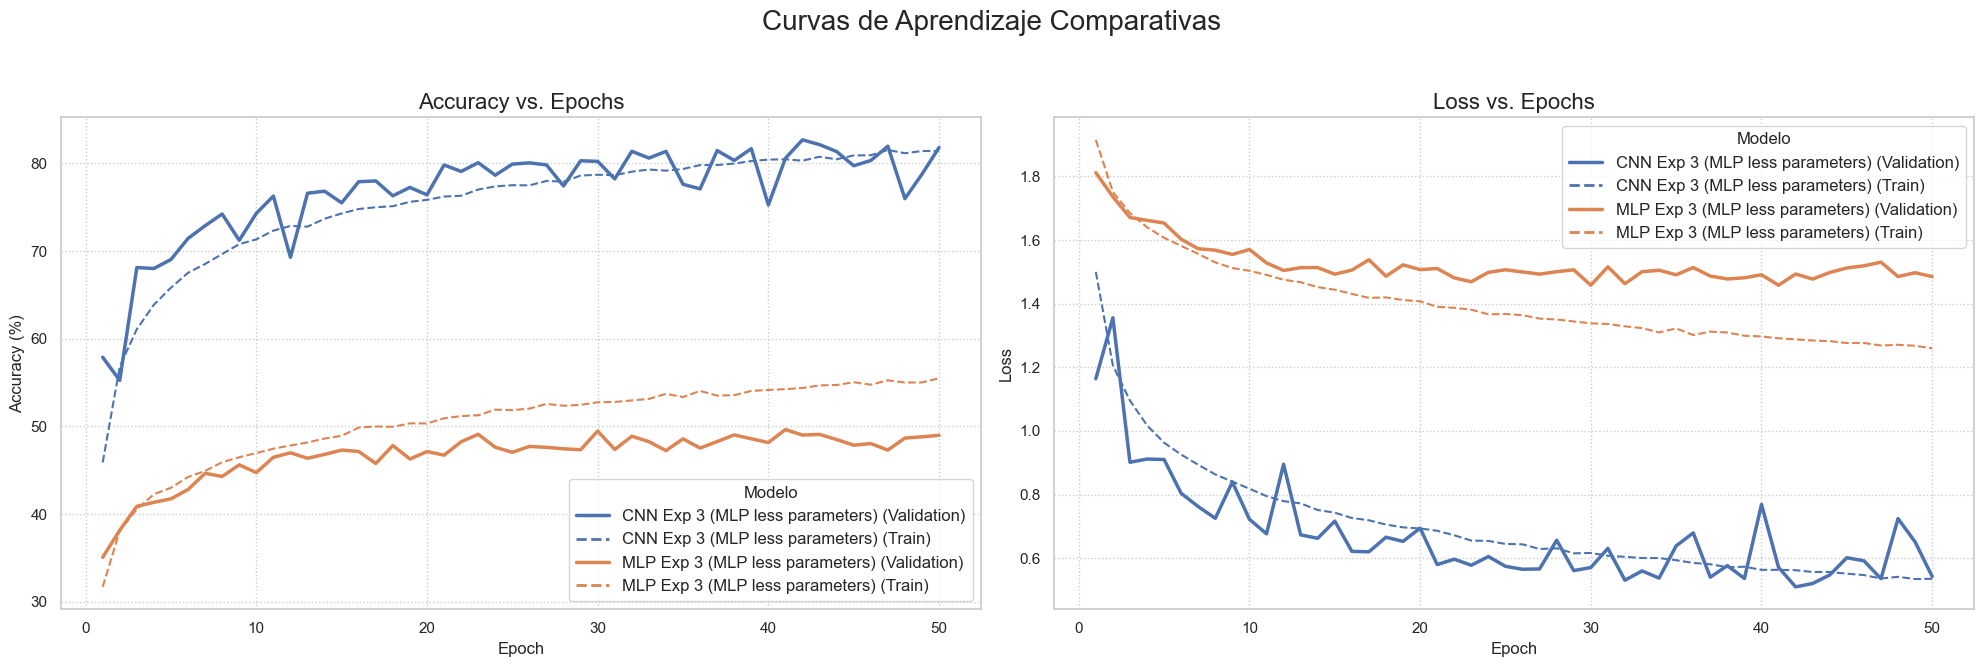

In [22]:
# Importar Line2D para crear la leyenda manual
from matplotlib.lines import Line2D

if not full_history_df.empty:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
    fig.suptitle('Curvas de Aprendizaje Comparativas', fontsize=20)
    
    # --- Obtener nombres y colores de modelos ---
    # Esto nos permite crear la leyenda dinámicamente
    model_names = full_history_df['model'].unique()
    palette = sns.color_palette(n_colors=len(model_names))
    
    # --- Gráfica 1: Precisión (Accuracy) ---
    sns.lineplot(data=full_history_df, x='epoch', y='val_acc', hue='model', 
                 palette=palette, linestyle='-', linewidth=2.5, ax=ax1, legend=False)
    sns.lineplot(data=full_history_df, x='epoch', y='train_acc', hue='model', 
                 palette=palette, linestyle='--', ax=ax1, legend=False)

    ax1.set_title('Accuracy vs. Epochs', fontsize=16)
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_xlabel('Epoch')
    ax1.grid(True, linestyle=':') # Añadir grid
    
    # --- Gráfica 2: Pérdida (Loss) ---
    sns.lineplot(data=full_history_df, x='epoch', y='val_loss', hue='model', 
                 palette=palette, linestyle='-', linewidth=2.5, ax=ax2, legend=False)
    # ¡LÍNEA AÑADIDA!
    sns.lineplot(data=full_history_df, x='epoch', y='train_loss', hue='model', 
                 palette=palette, linestyle='--', ax=ax2, legend=False)
    
    ax2.set_title('Loss vs. Epochs', fontsize=16)
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.grid(True, linestyle=':') # Añadir grid
    
    # --- Crear Leyenda Manual "Bien Definida" ---
    legend_elements = []
    for i, name in enumerate(model_names):
        legend_elements.append(
            Line2D([0], [0], color=palette[i], lw=2.5, label=f'{name} (Validation)')
        )
        legend_elements.append(
            Line2D([0], [0], color=palette[i], lw=2, ls='--', label=f'{name} (Train)')
        )

    # Aplicar la leyenda en la mejor ubicación "en medio"
    ax1.legend(handles=legend_elements, loc='best', title='Modelo', fontsize=12)
    ax2.legend(handles=legend_elements, loc='best', title='Modelo', fontsize=12)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustar para el super-título
    plt.savefig('comparative_learning_curves_exp3.png', dpi=300)
    plt.show()
else:
    print("No hay datos de historial para graficar.")

## 4.1 Matrices de Confusión
Estas matrices nos muestran *dónde* se confunden los modelos. La diagonal principal (de arriba-izquierda a abajo-derecha) representa las predicciones correctas. Los números fuera de la diagonal son errores.

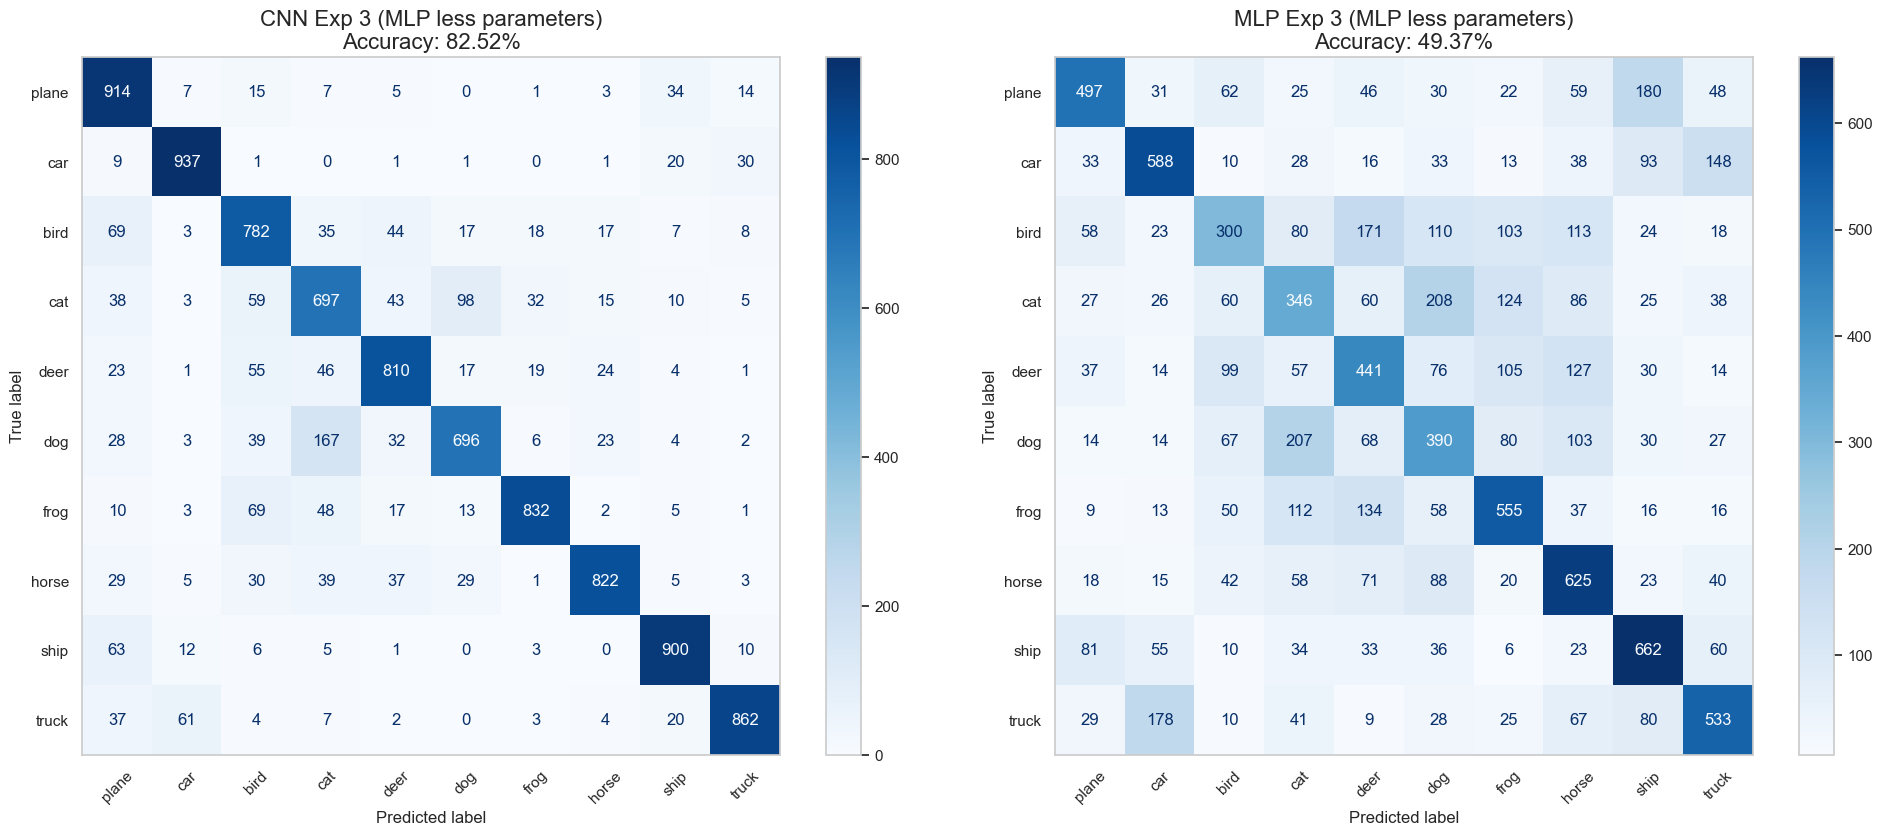

In [23]:
# --- Graficar Matrices de Confusión ---
if loaded_results:
    n_exp = len(loaded_results)
    # Crear una cuadrícula (máx 2 columnas)
    ncols = min(n_exp, 2)
    nrows = (n_exp + 1) // ncols
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10 * ncols, 8 * nrows), squeeze=False)
    
    # Iterar sobre los resultados y los ejes
    for i, (name, data) in enumerate(loaded_results.items()):
        ax = axes.flat[i]
        
        cm = confusion_matrix(data['all_labels'], data['all_predictions'])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
        
        disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
        
        # --- LÍNEA AÑADIDA ---
        # Desactiva la cuadrícula de fondo para esta gráfica
        ax.grid(False) 
        # ---
        
        ax.set_title(f"{name}\nAccuracy: {data['test_accuracy']:.2f}%", fontsize=16)

    # Ocultar ejes no usados
    for j in range(i + 1, len(axes.flat)):
        axes.flat[j].set_visible(False)
        
    plt.tight_layout()
    plt.savefig('comparative_confusion_matrices_exp3.png', dpi=300)
    plt.show()
else:
    print("No hay resultados cargados para mostrar matrices.")

## 5.1 Conclusión del Análisis del experimento 2

Precisión: La CNN es drásticamente superior, superando al MLP por aproximadamente 33 puntos porcentuales.

Sobreajuste: El MLP sufre de un sobreajuste menor al experimento anterior, visible en la gran brecha entre sus curvas de entrenamiento y validación. La CNN generaliza mucho mejor siendo que tienen la misma cantidad de parámetros.

Eficiencia: La CNN es mucho más eficiente. Logró una precisión superior con los mismos parámetros que el MLP y mantuvo casi el porcentaje respecto al experimento 2 pero con mucho menos parámetros.

Confusiones: El MLP comete errores más graves (ej. "bird" vs "cat"), mientras que la CNN sigue cometiendo confusiones más lógicas (ej. "cat" vs "dog"), sugiriendo que aprende características de mayor calidad.

# Experimento 4

Se trata de estresar a la CNN y MLP al probar si una traslación en el test es suficiente para que colapse alguna o ambas.

In [24]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import os

# Configurar el estilo de Seaborn para gráficos más bonitos
sns.set_theme(style="whitegrid")
print("Librerías importadas.")

EXPERIMENT_FILES = [
    'results_cnn_exp4.pth',
    'results_mlp_exp4.pth'
]


Librerías importadas.


## 1.1 Carga de Archivos de Resultados
Cargamos los archivos `.pth` generados por los scripts de entrenamiento. Estos archivos contienen los historiales de entrenamiento, las predicciones finales y las métricas clave.

In [25]:
# --- Cargar datos de todos los experimentos ---
loaded_results = {}
all_histories_df = []
classes = []

def load_results(filename):
    """Carga un archivo de resultados de forma segura."""
    if os.path.exists(filename):
        print(f"Cargando: {filename}")
        
        # --- ¡CORRECCIÓN AQUÍ! ---
        # Necesitas 'weights_only=False' porque estás cargando
        # un diccionario con datos de Python/Numpy, no solo pesos.
        return torch.load(filename, weights_only=False) 
    
    else:
        print(f"¡ADVERTENCIA! No se encontró el archivo: {filename}")
        return None

for file in EXPERIMENT_FILES:
    results = load_results(file)
    if results:
        exp_name = results.get('experiment_name', file)
        loaded_results[exp_name] = results
        
        # Guardar clases (solo una vez)
        if not classes and 'classes' in results:
            classes = results['classes']
            
        # Preparar datos para las curvas de aprendizaje
        df = pd.DataFrame(results['history'])
        df['epoch'] = df.index + 1
        df['model'] = exp_name
        all_histories_df.append(df)

# Combinar todos los historiales en un solo DataFrame
if all_histories_df:
    full_history_df = pd.concat(all_histories_df, ignore_index=True)
    print(f"\nSe cargaron {len(loaded_results)} conjuntos de resultados.")
else:
    print("\nNo se cargó ningún resultado. Revisa los nombres de los archivos.")
    full_history_df = pd.DataFrame()

Cargando: results_cnn_exp4.pth
Cargando: results_mlp_exp4.pth

Se cargaron 2 conjuntos de resultados.


## 2.1. Resumen
Comparamos las métricas clave: precisión final, número de parámetros y tiempo de entrenamiento. Esto nos da una visión general del "costo-beneficio" de cada arquitectura.  

In [26]:
import pandas as pd

print("\n--- 9. Detailed View (Precision, Recall, F1) by Class - SHIFTED DATA ---")

# List to store data for each class and model
per_class_data_shifted = []

# Iterate over the results we already loaded
for name, data in loaded_results.items():
    
    # --- KEY CHANGE! ---
    # Only process experiments that have "shifted" results
    if 'classification_report_dict_shifted' in data:
        report_dict = data.get('classification_report_dict_shifted', {})
        
        # Iterate over each class name
        for class_name in classes:
            if class_name in report_dict:
                class_metrics = report_dict[class_name]
                
                per_class_data_shifted.append({
                    'Experiment': name,
                    'Clase': class_name,
                    'Precision': class_metrics.get('precision', 0.0),
                    'Recall': class_metrics.get('recall', 0.0),
                    'F1-Score': class_metrics.get('f1-score', 0.0),
                })

# Create the DataFrame
if per_class_data_shifted:
    per_class_df_shifted = pd.DataFrame(per_class_data_shifted)

    # --- Show all metrics (Detailed view) ---
    detailed_pivot_shifted = per_class_df_shifted.pivot(
        index='Clase', 
        columns='Experiment', 
        values=['Precision', 'Recall', 'F1-Score']
    )
    
    # Reorder columns to group by experiment and sort
    display(detailed_pivot_shifted.swaplevel(0, 1, axis=1).sort_index(axis=1).style.format("{:.3f}"))

else:
    print("No detailed classification report data found for 'shifted' results.")
    print("Ensure you have run the invariance experiment scripts (e.g., train_cnn_invariance.py, train_mlp_invariance.py)")


--- 9. Detailed View (Precision, Recall, F1) by Class - SHIFTED DATA ---


In [27]:
import numpy as np
import pandas as pd

print("\n--- 10. Comparison of All Key Metrics ---")

all_metrics_data = []

# Iterate over the loaded results
for name, data in loaded_results.items():
    
    # --- Check experiment type ---
    # Check if it's an invariance experiment (has 'normal' and 'shifted' keys)
    if 'test_accuracy_normal' in data:
        acc_normal = data.get('test_accuracy_normal', 0.0)
        acc_shifted = data.get('test_accuracy_shifted', 0.0)
        # Use the 'normal' report for F1-score comparison
        report_dict = data.get('classification_report_dict_normal', {})
        test_time = data.get('total_inference_time_sec_normal', 0.0)
        
    # Else, it's a baseline experiment (like exp1)
    else:
        acc_normal = data.get('test_accuracy', 0.0)
        acc_shifted = np.nan # Not applicable
        report_dict = data.get('classification_report_dict', {})
        test_time = data.get('total_inference_time_sec', 0.0)
        
    # Extract the 'weighted avg' metrics
    weighted_avg_metrics = report_dict.get('weighted avg', {})
    
    all_metrics_data.append({
        'Experiment': name,
        
        # --- Performance Metrics ---
        'Accuracy (Normal)': acc_normal,
        'Accuracy (Shifted)': acc_shifted, # <-- ADDED
        'F1-Score (Weighted)': weighted_avg_metrics.get('f1-score', 0.0),
        
        # --- Cost Metrics (Runtimes & Params) ---
        'Total Params': data.get('total_params', 0),
        'Total Time (min)': data.get('total_training_time_sec', 0.0) / 60.0,
        'Time / Epoch (s)': np.mean(data['history'].get('epoch_time', [0.0])),
        'Test Time (Normal)': test_time
    })

# Create the DataFrame
if all_metrics_data:
    # Reorder columns for logical grouping
    column_order = [
        'Accuracy (Normal)',
        'Accuracy (Shifted)', # <-- ADDED
        'F1-Score (Weighted)',
        'Total Params',
        'Total Time (min)', 
        'Time / Epoch (s)',
        'Test Time (Normal)'
    ]
    
    all_metrics_df = pd.DataFrame(all_metrics_data).set_index('Experiment')
    all_metrics_df = all_metrics_df[column_order] # Apply order
    
    # Format the output
    format_dict = {
        'Accuracy (Normal)': '{:.2f}%',
        'Accuracy (Shifted)': '{:.2f}%', # <-- ADDED
        'F1-Score (Weighted)': '{:.3f}',
        'Total Params': '{:,}',
        'Total Time (min)': '{:.2f}',
        'Time / Epoch (s)': '{:.2f}',
        'Test Time (Normal)': '{:.2f}'
    }
    
    # Use na_rep='N/A' to nicely format the 'Not Applicable' cells
    display(all_metrics_df.style.format(format_dict, na_rep='N/A'))
else:
    print("No results found in reports.")


--- 10. Comparison of All Key Metrics ---


,Accuracy (Normal),Accuracy (Shifted),F1-Score (Weighted),Total Params,Total Time (min),Time / Epoch (s),Test Time (Normal)
Experiment,,,,,,,
CNN (Baseline) Invariance,84.60%,74.07%,0.844,"357,514",7.42,8.90,0.64
MLP (Baseline) Invariance,51.78%,21.19%,0.516,"1,738,890",3.64,4.37,0.47


## 3.1 Curvas de Aprendizaje (Accuracy y Pérdida)
Esta es la visualización más importante. Muestra cómo aprendió cada modelo a lo largo del tiempo.

* **Líneas Sólidas (-):** Accuracy/Pérdida de **Validación** (qué tan bien generaliza).
* **Líneas Punteadas (--):** Accuracy/Pérdida de **Entrenamiento** (qué tan bien memoriza).
* **Sobreajuste (Overfitting):** Ocurre cuando la línea de entrenamiento sigue mejorando mientras que la de validación se estanca o empeora (la brecha entre ambas se amplía).

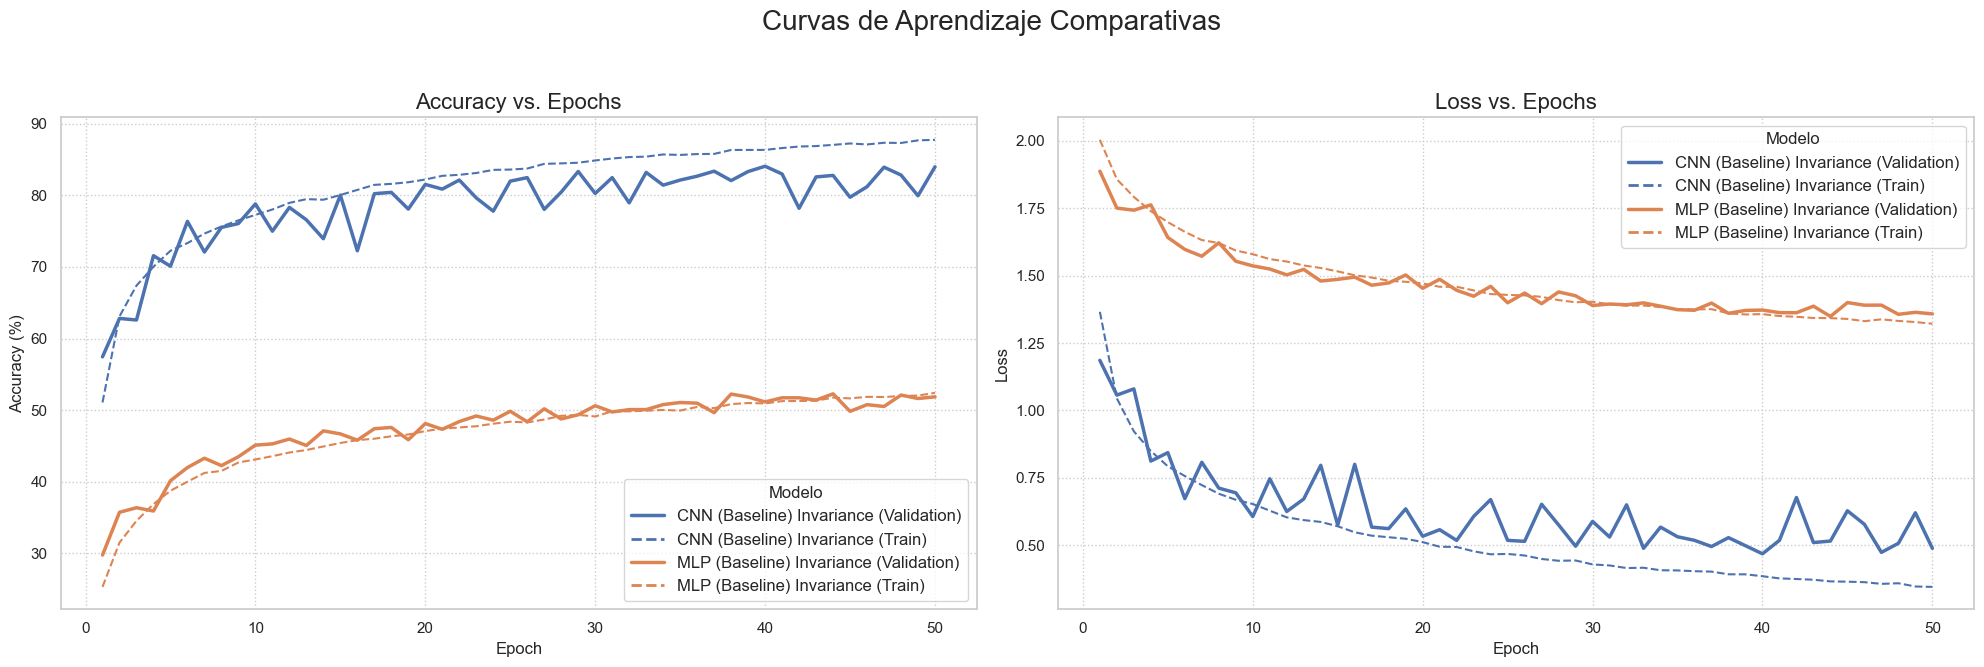

In [28]:
# Importar Line2D para crear la leyenda manual
from matplotlib.lines import Line2D

if not full_history_df.empty:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
    fig.suptitle('Curvas de Aprendizaje Comparativas', fontsize=20)
    
    # --- Obtener nombres y colores de modelos ---
    # Esto nos permite crear la leyenda dinámicamente
    model_names = full_history_df['model'].unique()
    palette = sns.color_palette(n_colors=len(model_names))
    
    # --- Gráfica 1: Precisión (Accuracy) ---
    sns.lineplot(data=full_history_df, x='epoch', y='val_acc', hue='model', 
                 palette=palette, linestyle='-', linewidth=2.5, ax=ax1, legend=False)
    sns.lineplot(data=full_history_df, x='epoch', y='train_acc', hue='model', 
                 palette=palette, linestyle='--', ax=ax1, legend=False)

    ax1.set_title('Accuracy vs. Epochs', fontsize=16)
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_xlabel('Epoch')
    ax1.grid(True, linestyle=':') # Añadir grid
    
    # --- Gráfica 2: Pérdida (Loss) ---
    sns.lineplot(data=full_history_df, x='epoch', y='val_loss', hue='model', 
                 palette=palette, linestyle='-', linewidth=2.5, ax=ax2, legend=False)
    # ¡LÍNEA AÑADIDA!
    sns.lineplot(data=full_history_df, x='epoch', y='train_loss', hue='model', 
                 palette=palette, linestyle='--', ax=ax2, legend=False)
    
    ax2.set_title('Loss vs. Epochs', fontsize=16)
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.grid(True, linestyle=':') # Añadir grid
    
    # --- Crear Leyenda Manual "Bien Definida" ---
    legend_elements = []
    for i, name in enumerate(model_names):
        legend_elements.append(
            Line2D([0], [0], color=palette[i], lw=2.5, label=f'{name} (Validation)')
        )
        legend_elements.append(
            Line2D([0], [0], color=palette[i], lw=2, ls='--', label=f'{name} (Train)')
        )

    # Aplicar la leyenda en la mejor ubicación "en medio"
    ax1.legend(handles=legend_elements, loc='best', title='Modelo', fontsize=12)
    ax2.legend(handles=legend_elements, loc='best', title='Modelo', fontsize=12)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustar para el super-título
    plt.savefig('comparative_learning_curves_exp4.png', dpi=300)
    plt.show()
else:
    print("No hay datos de historial para graficar.")

## 4.1 Matrices de Confusión
Estas matrices nos muestran *dónde* se confunden los modelos. La diagonal principal (de arriba-izquierda a abajo-derecha) representa las predicciones correctas. Los números fuera de la diagonal son errores.

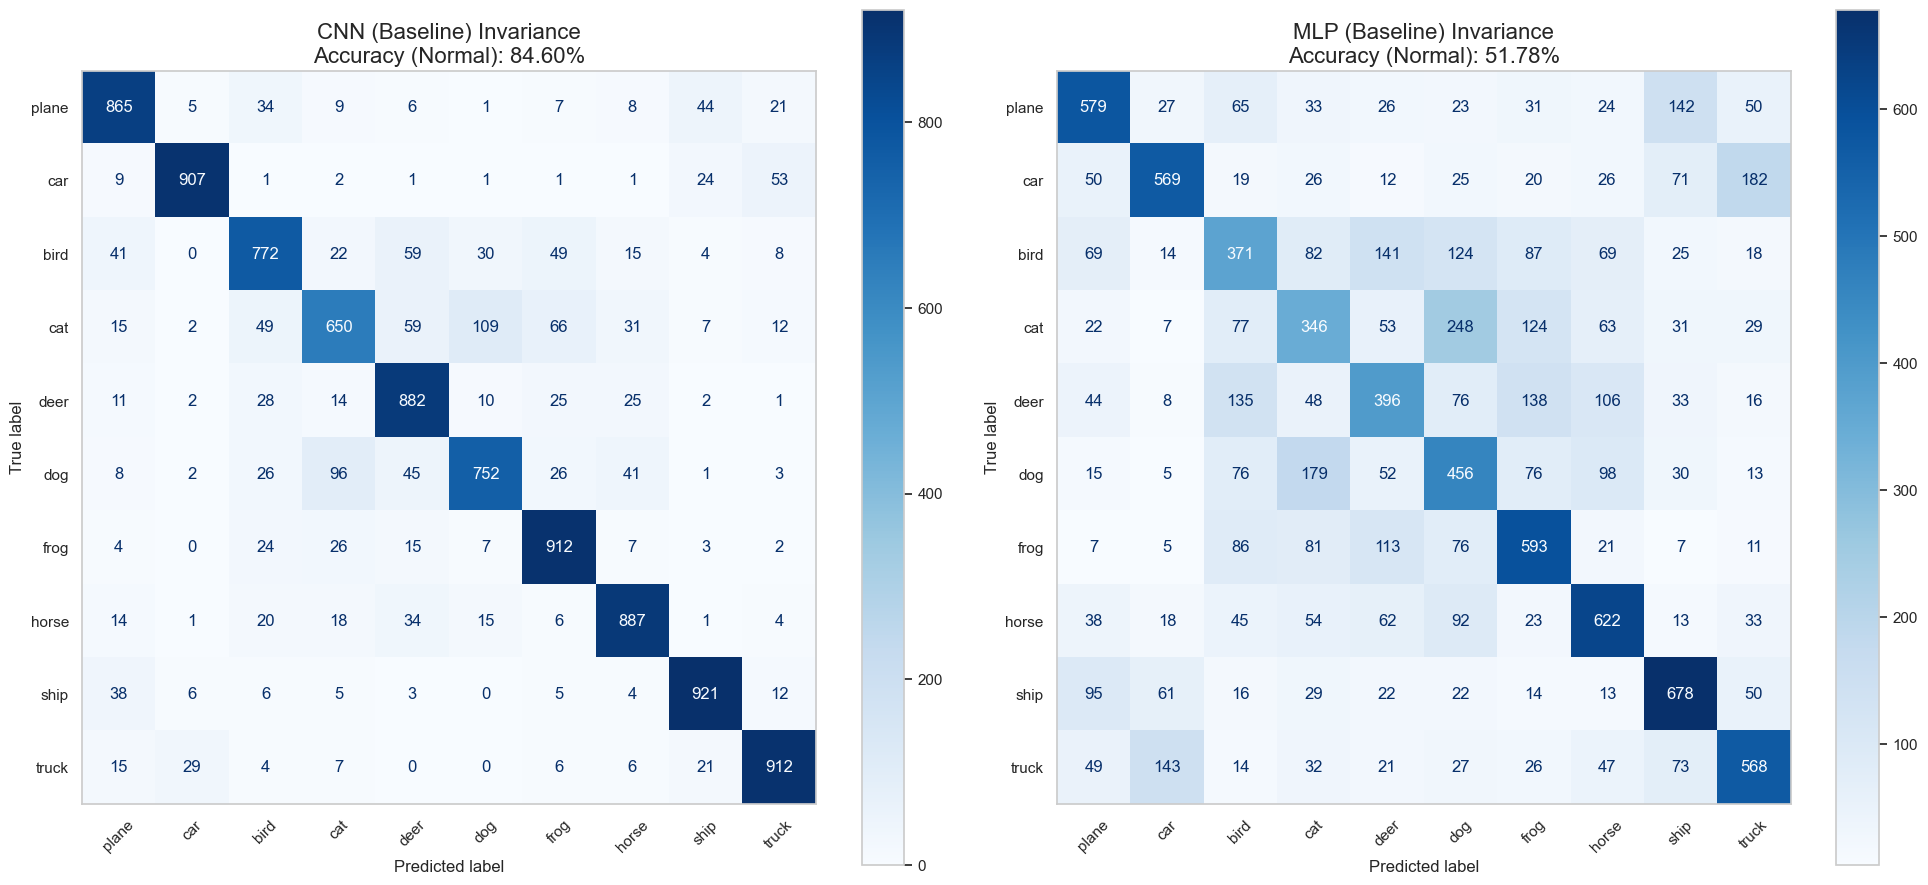

In [29]:
# --- Plot Confusion Matrices ---
if loaded_results:
    n_exp = len(loaded_results)
    # Create a grid (max 2 columns)
    ncols = min(n_exp, 2)
    nrows = (n_exp + 1) // ncols
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10 * ncols, 9 * nrows), squeeze=False)
    
    # Iterate over the results and axes
    for i, (name, data) in enumerate(loaded_results.items()):
        ax = axes.flat[i]
        
        # --- LOGIC CORRECTION ---
        # Check if this is an invariance experiment
        if 'all_labels_normal' in data:
            labels = data['all_labels_normal']
            predictions = data['all_predictions_normal']
            accuracy = data['test_accuracy_normal']
            title = f"{name}\nAccuracy (Normal): {accuracy:.2f}%"
        
        # Else, it's a baseline experiment
        elif 'all_labels' in data:
            labels = data['all_labels']
            predictions = data['all_predictions']
            accuracy = data['test_accuracy']
            title = f"{name}\nAccuracy: {accuracy:.2f}%"
        
        # Else, no data found
        else:
            ax.text(0.5, 0.5, 'Matrix data not found in file', 
                    ha='center', va='center', transform=ax.transAxes)
            ax.set_title(name, fontsize=16)
            ax.grid(False)
            continue # Skip to the next plot
        # ---
        
        cm = confusion_matrix(labels, predictions)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
        
        disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
        
        # --- Remove background grid ---
        ax.grid(False) 
        # ---
        
        ax.set_title(title, fontsize=16)

    # Hide unused axes
    for j in range(i + 1, len(axes.flat)):
        axes.flat[j].set_visible(False)
        
    plt.tight_layout()
    plt.savefig('comparative_confusion_matrices_exp4.png', dpi=300) # Generic name
    plt.show()
else:
    print("No results are loaded to display matrices.")

## 5.1 Conclusión del Análisis del experimento 4

Invarianza a la Traslación: La CNN dominó esta prueba. Su precisión bajó solo 10.5 puntos (de 84.6% a 74.1%), demostrando una alta robustez. En cambio, el MLP colapsó completamente, perdiendo más de 30 puntos (de 51.8% a 21.2%), probando su incapacidad para generalizar espacialmente.

Robustez Arquitectónica: El MLP demostró que su conocimiento depende de la ubicación exacta de los píxeles que vio durante el entrenamiento. La CNN, al usar filtros compartidos, aprende a reconocer características (como "orejas" o "ruedas") sin importar en qué parte de la imagen se encuentren.

Eficiencia: La CNN no solo fue más robusta, sino que logró esta robustez usando casi 5 veces menos parámetros que el MLP (357k vs 1.7M). Esto prueba que su rendimiento superior proviene de una arquitectura más inteligente, no de tener más parámetros.

Análisis de Falla: El colapso del MLP a 21.2% significa que dejó de distinguir la mayoría de las clases. La CNN, al retener un 74.1%, demostró que todavía podía diferenciar "gatos" de "perros" y "coches" de "camiones" incluso después de moverlos, confirmando que aprendió las características correctas.

# Experimento 5

Se usa la misma arquitectura del experimento 3 (el de menos parámetros) pero corriendo a traves del cpu.

In [30]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import os

# Configurar el estilo de Seaborn para gráficos más bonitos
sns.set_theme(style="whitegrid")
print("Librerías importadas.")

EXPERIMENT_FILES = [
    'results_CNN_exp5.pth',
    'results_MLP_exp5.pth'
]


Librerías importadas.


## 1.1 Carga de Archivos de Resultados
Cargamos los archivos `.pth` generados por los scripts de entrenamiento. Estos archivos contienen los historiales de entrenamiento, las predicciones finales y las métricas clave.

In [31]:
# --- Cargar datos de todos los experimentos ---
loaded_results = {}
all_histories_df = []
classes = []

def load_results(filename):
    """Carga un archivo de resultados de forma segura."""
    if os.path.exists(filename):
        print(f"Cargando: {filename}")
        
        # --- ¡CORRECCIÓN AQUÍ! ---
        # Necesitas 'weights_only=False' porque estás cargando
        # un diccionario con datos de Python/Numpy, no solo pesos.
        return torch.load(filename, weights_only=False) 
    
    else:
        print(f"¡ADVERTENCIA! No se encontró el archivo: {filename}")
        return None

for file in EXPERIMENT_FILES:
    results = load_results(file)
    if results:
        exp_name = results.get('experiment_name', file)
        loaded_results[exp_name] = results
        
        # Guardar clases (solo una vez)
        if not classes and 'classes' in results:
            classes = results['classes']
            
        # Preparar datos para las curvas de aprendizaje
        df = pd.DataFrame(results['history'])
        df['epoch'] = df.index + 1
        df['model'] = exp_name
        all_histories_df.append(df)

# Combinar todos los historiales en un solo DataFrame
if all_histories_df:
    full_history_df = pd.concat(all_histories_df, ignore_index=True)
    print(f"\nSe cargaron {len(loaded_results)} conjuntos de resultados.")
else:
    print("\nNo se cargó ningún resultado. Revisa los nombres de los archivos.")
    full_history_df = pd.DataFrame()

Cargando: results_CNN_exp5.pth
Cargando: results_MLP_exp5.pth

Se cargaron 2 conjuntos de resultados.


## 2.1. Resumen
Comparamos las métricas clave: precisión final, número de parámetros y tiempo de entrenamiento. Esto nos da una visión general del "costo-beneficio" de cada arquitectura.  

In [32]:
import pandas as pd

print("\n--- 9. Detailed View (Precision, Recall, F1) by Class ---")

# List to store data for each class and model
per_class_data = []

# Iterate over the results we already loaded
for name, data in loaded_results.items():
    report_dict = data.get('classification_report_dict', {})
    
    # Iterate over each class name
    for class_name in classes:
        if class_name in report_dict:
            class_metrics = report_dict[class_name]
            
            per_class_data.append({
                'Experiment': name,
                'Clase': class_name,
                'Precision': class_metrics.get('precision', 0.0),
                'Recall': class_metrics.get('recall', 0.0),
                'F1-Score': class_metrics.get('f1-score', 0.0),
            })

# Create the DataFrame
if per_class_data:
    per_class_df = pd.DataFrame(per_class_data)

    # --- Show all metrics (Detailed view) ---
    detailed_pivot = per_class_df.pivot(
        index='Clase', 
        columns='Experiment', 
        values=['Precision', 'Recall', 'F1-Score']
    )
    
    # Reorder columns to group by experiment (MLP -> P, R, F1 | CNN -> P, R, F1)
    # and then sort alphabetically by experiment name
    display(detailed_pivot.swaplevel(0, 1, axis=1).sort_index(axis=1).style.format("{:.3f}"))

else:
    print("No detailed classification report data was found.")


--- 9. Detailed View (Precision, Recall, F1) by Class ---


In [33]:
import numpy as np
import pandas as pd

print("\n--- 10. Comparison of Weighted Average Metrics & Runtimes ---")

weighted_avg_data = []

# Iterate over the loaded results
for name, data in loaded_results.items():
    report_dict = data.get('classification_report_dict', {})
    
    # Extract the 'weighted avg' metrics
    weighted_avg_metrics = report_dict.get('weighted avg', {})
    
    if weighted_avg_metrics:
        weighted_avg_data.append({
            'Experiment': name,
            
            # --- Performance Metrics ---
            'Test Accuracy': data.get('test_accuracy', 0.0),
            'F1-Score (Weighted)': weighted_avg_metrics.get('f1-score', 0.0),
            'Precision (Weighted)': weighted_avg_metrics.get('precision', 0.0),
            'Recall (Weighted)': weighted_avg_metrics.get('recall', 0.0),
            
            # --- Cost Metrics (Runtimes & Params) ---
            'Total Params': data.get('total_params', 0), # <-- ADDED
            'Total Time (min)': data.get('total_training_time_sec', 0.0) / 60.0,
            'Time / Epoch (s)': np.mean(data['history'].get('epoch_time', [0.0])),
            'Test Time (s)': data.get('total_inference_time_sec', 0.0)
        })

# Create the DataFrame
if weighted_avg_data:
    # Reorder columns for logical grouping
    column_order = [
        'Test Accuracy', 
        'F1-Score (Weighted)', 
        'Precision (Weighted)', 
        'Recall (Weighted)',
        'Total Params', # <-- ADDED
        'Total Time (min)', 
        'Time / Epoch (s)',
        'Test Time (s)'
    ]
    
    weighted_avg_df = pd.DataFrame(weighted_avg_data).set_index('Experiment')
    weighted_avg_df = weighted_avg_df[column_order] # Apply order
    
    # Format the output
    format_dict = {
        'Test Accuracy': '{:.2f}%',
        'F1-Score (Weighted)': '{:.3f}',
        'Precision (Weighted)': '{:.3f}',
        'Recall (Weighted)': '{:.3f}',
        'Total Params': '{:,}', # <-- ADDED (adds comma separator)
        'Total Time (min)': '{:.2f}',
        'Time / Epoch (s)': '{:.2f}',
        'Test Time (s)': '{:.2f}'
    }
    
    display(weighted_avg_df.style.format(format_dict))
else:
    print("No 'weighted avg' data found in reports.")


--- 10. Comparison of Weighted Average Metrics & Runtimes ---


,Test Accuracy,F1-Score (Weighted),Precision (Weighted),Recall (Weighted),Total Params,Total Time (min),Time / Epoch (s),Test Time (s)
Experiment,,,,,,,,
CNN Exp 5 (CPU),82.01%,0.819,0.825,0.820,"357,514",25.15,30.18,2.71
MLP Exp 5 (CPU),48.72%,0.481,0.486,0.487,"357,638",1.39,1.67,0.29


## 3.1 Curvas de Aprendizaje (Accuracy y Pérdida)
Esta es la visualización más importante. Muestra cómo aprendió cada modelo a lo largo del tiempo.

* **Líneas Sólidas (-):** Accuracy/Pérdida de **Validación** (qué tan bien generaliza).
* **Líneas Punteadas (--):** Accuracy/Pérdida de **Entrenamiento** (qué tan bien memoriza).
* **Sobreajuste (Overfitting):** Ocurre cuando la línea de entrenamiento sigue mejorando mientras que la de validación se estanca o empeora (la brecha entre ambas se amplía).

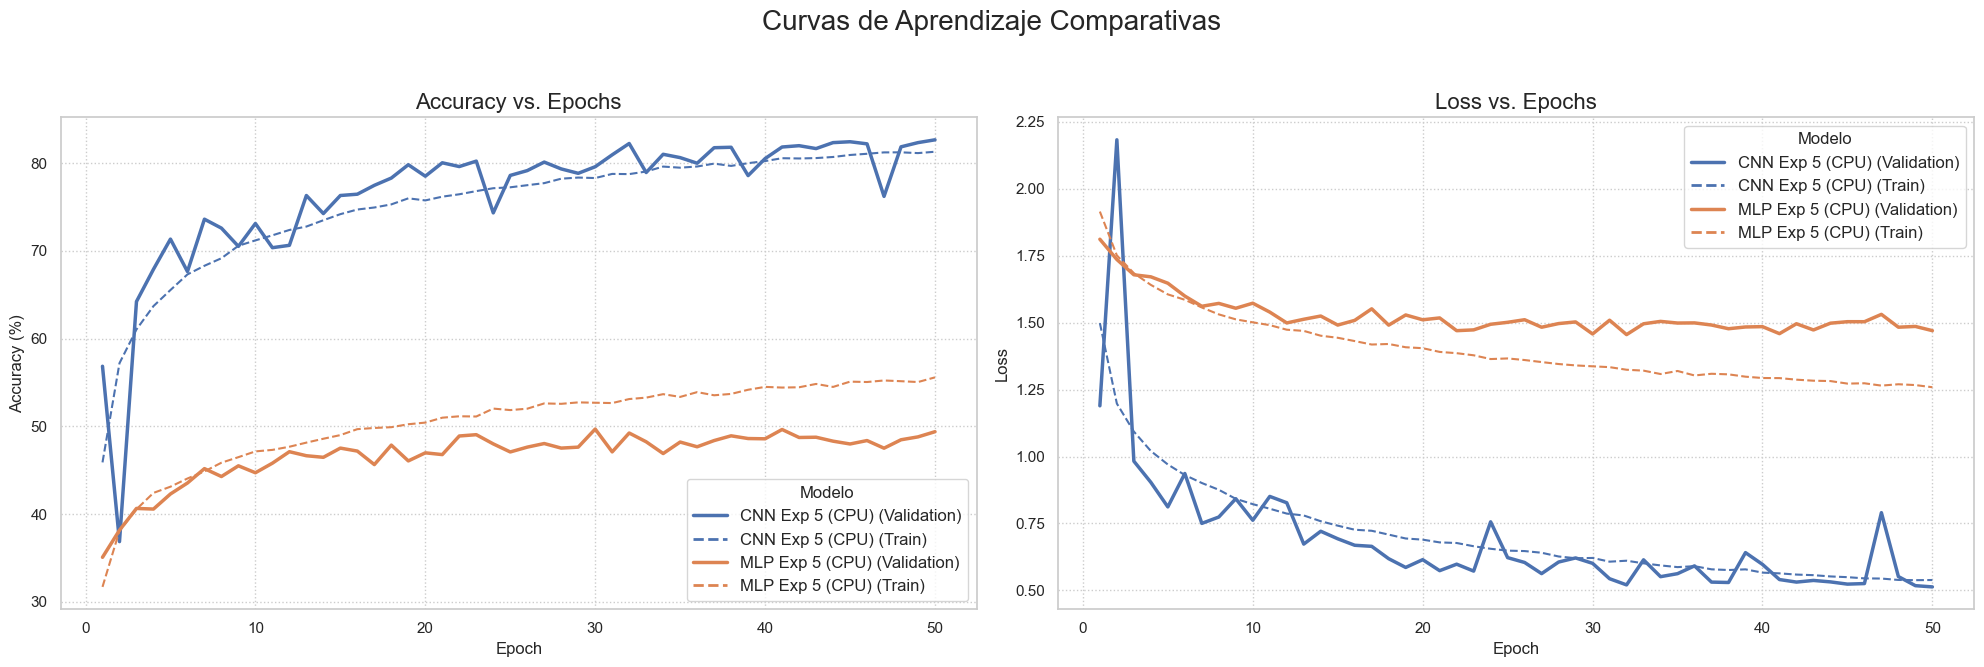

In [34]:
# Importar Line2D para crear la leyenda manual
from matplotlib.lines import Line2D

if not full_history_df.empty:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
    fig.suptitle('Curvas de Aprendizaje Comparativas', fontsize=20)
    
    # --- Obtener nombres y colores de modelos ---
    # Esto nos permite crear la leyenda dinámicamente
    model_names = full_history_df['model'].unique()
    palette = sns.color_palette(n_colors=len(model_names))
    
    # --- Gráfica 1: Precisión (Accuracy) ---
    sns.lineplot(data=full_history_df, x='epoch', y='val_acc', hue='model', 
                 palette=palette, linestyle='-', linewidth=2.5, ax=ax1, legend=False)
    sns.lineplot(data=full_history_df, x='epoch', y='train_acc', hue='model', 
                 palette=palette, linestyle='--', ax=ax1, legend=False)

    ax1.set_title('Accuracy vs. Epochs', fontsize=16)
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_xlabel('Epoch')
    ax1.grid(True, linestyle=':') # Añadir grid
    
    # --- Gráfica 2: Pérdida (Loss) ---
    sns.lineplot(data=full_history_df, x='epoch', y='val_loss', hue='model', 
                 palette=palette, linestyle='-', linewidth=2.5, ax=ax2, legend=False)
    # ¡LÍNEA AÑADIDA!
    sns.lineplot(data=full_history_df, x='epoch', y='train_loss', hue='model', 
                 palette=palette, linestyle='--', ax=ax2, legend=False)
    
    ax2.set_title('Loss vs. Epochs', fontsize=16)
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.grid(True, linestyle=':') # Añadir grid
    
    # --- Crear Leyenda Manual "Bien Definida" ---
    legend_elements = []
    for i, name in enumerate(model_names):
        legend_elements.append(
            Line2D([0], [0], color=palette[i], lw=2.5, label=f'{name} (Validation)')
        )
        legend_elements.append(
            Line2D([0], [0], color=palette[i], lw=2, ls='--', label=f'{name} (Train)')
        )

    # Aplicar la leyenda en la mejor ubicación "en medio"
    ax1.legend(handles=legend_elements, loc='best', title='Modelo', fontsize=12)
    ax2.legend(handles=legend_elements, loc='best', title='Modelo', fontsize=12)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustar para el super-título
    plt.savefig('comparative_learning_curves_exp5.png', dpi=300)
    plt.show()
else:
    print("No hay datos de historial para graficar.")

## 4.1 Matrices de Confusión
Estas matrices nos muestran *dónde* se confunden los modelos. La diagonal principal (de arriba-izquierda a abajo-derecha) representa las predicciones correctas. Los números fuera de la diagonal son errores.

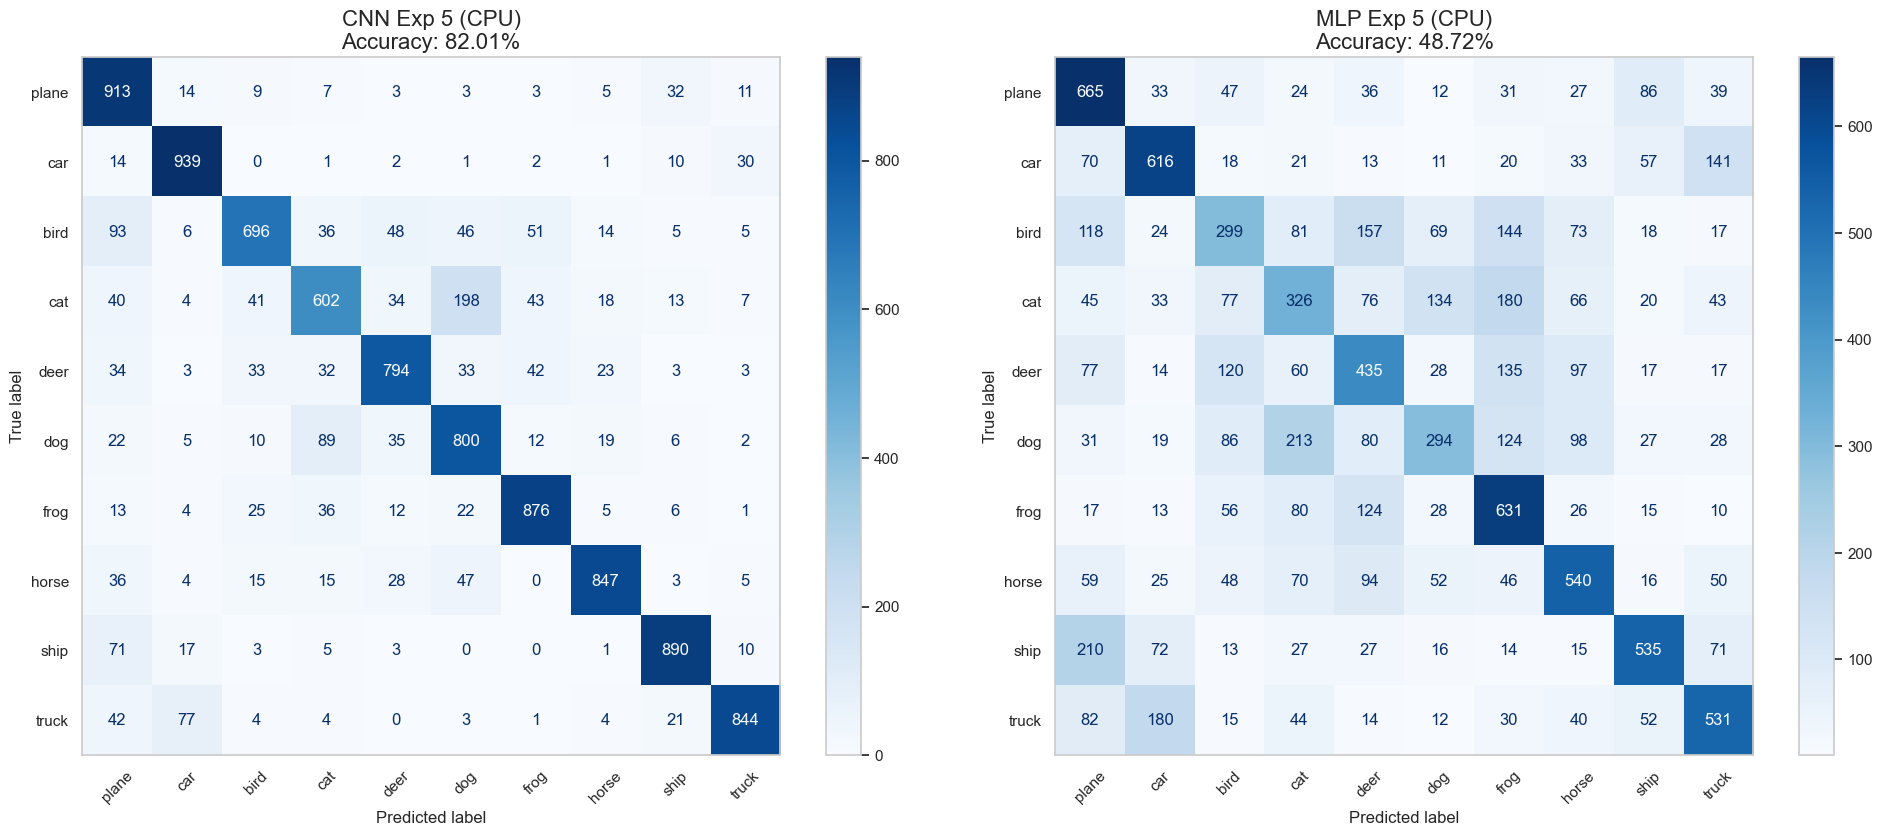

In [35]:
# --- Graficar Matrices de Confusión ---
if loaded_results:
    n_exp = len(loaded_results)
    # Crear una cuadrícula (máx 2 columnas)
    ncols = min(n_exp, 2)
    nrows = (n_exp + 1) // ncols
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10 * ncols, 8 * nrows), squeeze=False)
    
    # Iterar sobre los resultados y los ejes
    for i, (name, data) in enumerate(loaded_results.items()):
        ax = axes.flat[i]
        
        cm = confusion_matrix(data['all_labels'], data['all_predictions'])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
        
        disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
        
        # --- LÍNEA AÑADIDA ---
        # Desactiva la cuadrícula de fondo para esta gráfica
        ax.grid(False) 
        # ---
        
        ax.set_title(f"{name}\nAccuracy: {data['test_accuracy']:.2f}%", fontsize=16)

    # Ocultar ejes no usados
    for j in range(i + 1, len(axes.flat)):
        axes.flat[j].set_visible(False)
        
    plt.tight_layout()
    plt.savefig('comparative_confusion_matrices_exp5.png', dpi=300)
    plt.show()
else:
    print("No hay resultados cargados para mostrar matrices.")

## 5.1 Conclusión del Análisis del experimento 5

Tiempo de Entrenamiento y Test (CPU): El MLP es significativamente más rápido en una CPU. Se entrenó ≈18 veces más rápido (1.39 min vs 25.15 min) y realizó la inferencia (test) ≈9 veces más rápido (0.29s vs 2.71s). Esto se debe a que las operaciones complejas y paralelas (convoluciones) de una CNN son muy ineficientes en una CPU, mientras que las multiplicaciones de matrices más simples del MLP no lo son.

Conclusión General: El MLP es más rápido en CPU, pero su rendimiento es inaceptablemente bajo. La arquitectura de la CNN es la razón definitiva de su alta precisión, y este experimento lo demuestra al aislar el beneficio arquitectónico del conteo de parámetros.